# About Dataset
## Context
Game of Thrones is a hit fantasy tv show based on the equally famous book series "A Song of Fire and Ice" by George RR Martin. The show is well known for its vastly complicated political landscape, large number of characters, and its frequent character deaths.

## Content
Of course, it goes without saying that this dataset contains spoilers.

This dataset combines three sources of data, all of which are based on information from the book series.

- Firstly, there is **battles.csv** which contains Chris Albon's **"The War of the Five Kings"** Dataset. Its a great collection of all of the battles in the series.

- Secondly we have **character-deaths.csv** from Erin Pierce and Ben Kahle. This dataset was created as a part of their **Bayesian Survival Analysis**.

- Finally we have a more comprehensive character dataset with **character-predictions.csv**. It includes their predictions on which character will die.

## Acknowledgements
- Firstly, there is battles.csv which contains Chris Albon's "The War of the Five Kings" Dataset, which can be found here: https://github.com/chrisalbon/war_of_the_five_kings_dataset . Its a great collection of all of the battles in the series.

- Secondly we have character-deaths.csv from Erin Pierce and Ben Kahle. This dataset was created as a part of their Bayesian Survival Analysis which can be found here: http://allendowney.blogspot.com/2015/03/bayesian-survival-analysis-for-game-of.html

- Codes references https://www.kaggle.com/code/shaildeliwala/exploratory-analysis-and-predictions and https://www.kaggle.com/code/tosmin/game-of-throns-eda

- Finally we have a more comprehensive character dataset with character-predictions.csv. This comes from the team at A Song of Ice and Data who scraped it from http://awoiaf.westeros.org/ . It also includes their predictions on which character will die, the methodology of which can be found here: https://got.show/machine-learning-algorithm-predicts-death-game-of-thrones



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
from plotnine import ggplot, aes, geom_point
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import scale
from scipy import stats
sns.set_style("darkgrid")
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings('ignore')
from xgboost import plot_importance
from xgboost import XGBClassifier as XGBC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score

In [2]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15., 6.]

These lines of code set some default plotting parameters for **Matplotlib figures**.

- The first line sets the font size for axis labels to 16 points
- The second and third lines set the font size for x and y tick labels to 14 points, respectively.
- The fourth line sets the font size for legend labels to 12 points.
- The fifth line sets the default figure size to be 15 inches wide and 6 inches tall.

By setting these parameters as defaults, any subsequent plot created with Matplotlib will use these settings unless overridden by specific arguments provided to the plotting functions.

In [3]:
battles = pd.read_csv("C:/Users/suman/Desktop/DS learn/Project/Study/exploratory-analysis-and-predictions/battles.csv")
character_deaths = pd.read_csv("C:/Users/suman/Desktop/DS learn/Project/Study/exploratory-analysis-and-predictions/character-deaths.csv")
character_predictions = pd.read_csv("C:/Users/suman/Desktop/DS learn/Project/Study/exploratory-analysis-and-predictions/character-predictions.csv")

## New attributes
These lines of code are modifying certain columns of two different Pandas dataframes, **"battles"** and **"character_predictions"**.

For **"battles"**:
- The first line creates a new column called **"defender_count"** by counting the number of non-null values in the **"defender_1"** through **"defender_4"** columns and subtracting from 4.
- The second line creates a new column called **"attacker_count"** by counting the number of non-null values in the **"attacker_1"** through **"attacker_4"** columns and subtracting from 4.
- The third line creates a new column called **"att_comm_count"** by first splitting the **"attacker_commander"** column on commas and then counting the number of resulting items. If the "attacker_commander" value is not a list (i.e., if it is NaN), the value for "att_comm_count" will be NaN.


For **"character_predictions"**:

The line creates a new column called **"no_of_books"** by summing up the values in columns whose names start with **"book"**(presumably indicating whether the character appears in each book of a series).


In [4]:
battles.loc[:, "defender_count"] = (4 - battles[["defender_1", "defender_2", "defender_3", "defender_4"]].isnull().sum(axis = 1))
battles.loc[:, "attacker_count"] = (4 - battles[["attacker_1", "attacker_2", "attacker_3", "attacker_4"]].isnull().sum(axis = 1))
battles.loc[:, "att_comm_count"] = [len(x) if type(x) == list else np.nan for x in battles.attacker_commander.str.split(",")]
character_predictions.loc[:, "no_of_books"] = character_predictions[[x for x in character_predictions.columns if x.startswith("book")]].sum(axis = 1)

# Exploratory Analysis

In [5]:
#1st five rows of battels data
battles.head()

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,...,defender_size,attacker_commander,defender_commander,summer,location,region,note,defender_count,attacker_count,att_comm_count
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,...,4000.0,Jaime Lannister,"Clement Piper, Vance",1.0,Golden Tooth,The Westerlands,NaN,1,1,1.0
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Baratheon,...,120.0,Gregor Clegane,Beric Dondarrion,1.0,Mummer's Ford,The Riverlands,NaN,1,1,1.0
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,...,10000.0,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood",1.0,Riverrun,The Riverlands,NaN,1,1,2.0
3,Battle of the Green Fork,298,4,Robb Stark,Joffrey/Tommen Baratheon,Stark,NaN,NaN,NaN,Lannister,...,20000.0,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist...",1.0,Green Fork,The Riverlands,NaN,1,1,5.0
4,Battle of the Whispering Wood,298,5,Robb Stark,Joffrey/Tommen Baratheon,Stark,Tully,NaN,NaN,Lannister,...,6000.0,"Robb Stark, Brynden Tully",Jaime Lannister,1.0,Whispering Wood,The Riverlands,NaN,1,2,2.0


In [6]:
# sneeking the last five rows of battels data
battles.tail()

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,...,defender_size,attacker_commander,defender_commander,summer,location,region,note,defender_count,attacker_count,att_comm_count
33,Second Seige of Storm's End,300,34,Joffrey/Tommen Baratheon,Stannis Baratheon,Baratheon,NaN,NaN,NaN,Baratheon,...,200.0,"Mace Tyrell, Mathis Rowan",Gilbert Farring,0.0,Storm's End,The Stormlands,NaN,1,1,2.0
34,Siege of Dragonstone,300,35,Joffrey/Tommen Baratheon,Stannis Baratheon,Baratheon,NaN,NaN,NaN,Baratheon,...,NaN,"Loras Tyrell, Raxter Redwyne",Rolland Storm,0.0,Dragonstone,The Stormlands,NaN,1,1,2.0
35,Siege of Riverrun,300,36,Joffrey/Tommen Baratheon,Robb Stark,Lannister,Frey,NaN,NaN,Tully,...,NaN,"Daven Lannister, Ryman Fey, Jaime Lannister",Brynden Tully,0.0,Riverrun,The Riverlands,NaN,1,2,3.0
36,Siege of Raventree,300,37,Joffrey/Tommen Baratheon,Robb Stark,Bracken,Lannister,NaN,NaN,Blackwood,...,NaN,"Jonos Bracken, Jaime Lannister",Tytos Blackwood,0.0,Raventree,The Riverlands,NaN,1,2,2.0
37,Siege of Winterfell,300,38,Stannis Baratheon,Joffrey/Tommen Baratheon,Baratheon,Karstark,Mormont,Glover,Bolton,...,8000.0,Stannis Baratheon,Roose Bolton,0.0,Winterfell,The North,NaN,2,4,1.0


In [7]:
# finding the datatype and non- null count of each row
battles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                38 non-null     object 
 1   year                38 non-null     int64  
 2   battle_number       38 non-null     int64  
 3   attacker_king       36 non-null     object 
 4   defender_king       35 non-null     object 
 5   attacker_1          38 non-null     object 
 6   attacker_2          10 non-null     object 
 7   attacker_3          3 non-null      object 
 8   attacker_4          2 non-null      object 
 9   defender_1          37 non-null     object 
 10  defender_2          2 non-null      object 
 11  defender_3          0 non-null      float64
 12  defender_4          0 non-null      float64
 13  attacker_outcome    37 non-null     object 
 14  battle_type         37 non-null     object 
 15  major_death         37 non-null     float64
 16  major_capt

In [8]:
#  no of battels along with name 
pd.melt(frame=battles, id_vars="year",value_vars="name")

,year,variable,value
0,298,name,Battle of the Golden Tooth
1,298,name,Battle at the Mummer's Ford
2,298,name,Battle of Riverrun
3,298,name,Battle of the Green Fork
4,298,name,Battle of the Whispering Wood
5,298,name,Battle of the Camps
6,298,name,Sack of Darry
7,299,name,Battle of Moat Cailin
8,299,name,Battle of Deepwood Motte
9,299,name,Battle of the Stony Shore


## Major death / capture events by year.
This line of code creates a bar plot using Matplotlib to visualize the total number of major death and capture events in each year in the "battles" Pandas dataframe.

- The first line groups the **"battles"** dataframe by year and calculates the sum of the **"major_death"** and **"major_capture"** columns for each year. This is used to create a new dataframe with just those two columns, **indexed by year**.

- The second line uses the **"plot.bar()"** function to create the bar plot from the new dataframe. The **"rot = 0"** argument specifies that the x-axis tick labels should be horizontal.

- The third line sets the x- and y-axis labels using the "xlabel" and "ylabel" methods of the plot object **"p"**, and sets the y-axis limits to be between 0 and 9 using the **"ylim"** method.

- The fourth line adds a legend to the plot using the **"legend"** method of the plot object "p", with the labels **"Major Deaths"** and **"Major Captures"** specified in a list. The **"_"** character is used to suppress the output of the **"set()"** function, since it doesn't return anything.

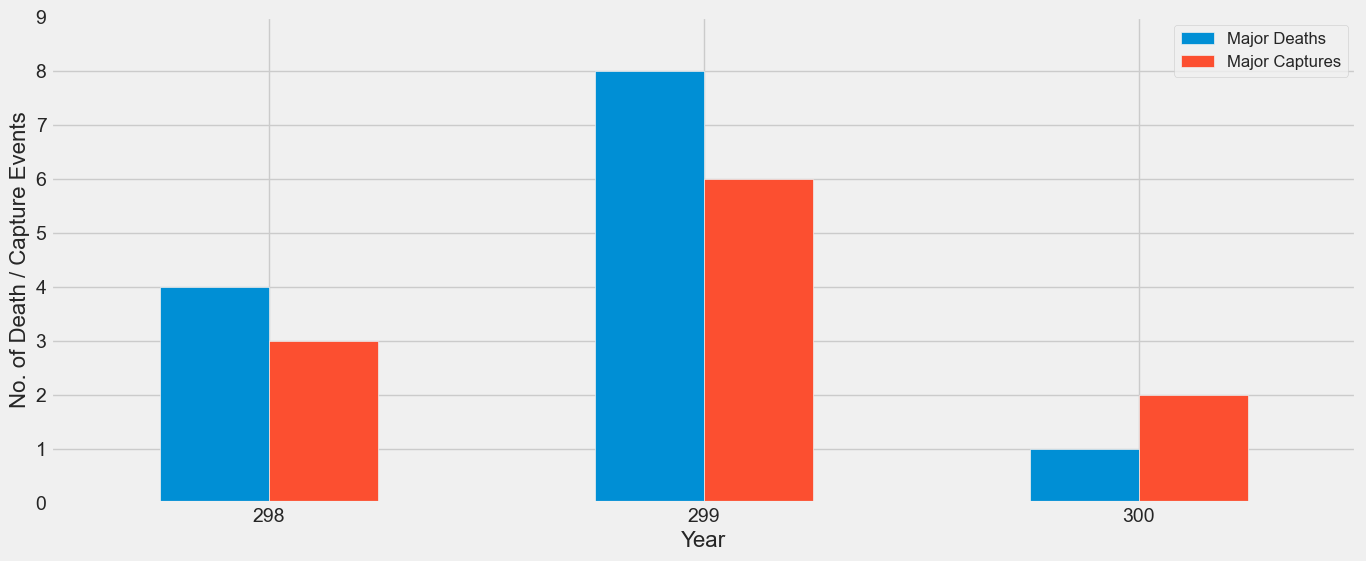

In [9]:
p = battles.groupby('year').sum()[["major_death", "major_capture"]].plot.bar(rot = 0)
_ = p.set(xlabel = "Year", ylabel = "No. of Death / Capture Events", ylim = (0, 9)), p.legend(["Major Deaths", "Major Captures"])

## Impact of army size on outcome
[Based on ggplot code from this notebook](https://github.com/chrisalbon/war_of_the_five_kings_dataset/blob/master/exploratory_analysis.ipynb)

The battles dataframe is used as the data source for the plot, and the **aes()** function is used to specify the variables to map to the x, y, and color aesthetics. The **geom_point()** function is used to create a scatter plot of the data points.

You can customize this plot further by adding additional layers, adjusting the axis labels and limits, and changing the color palette, among other things.

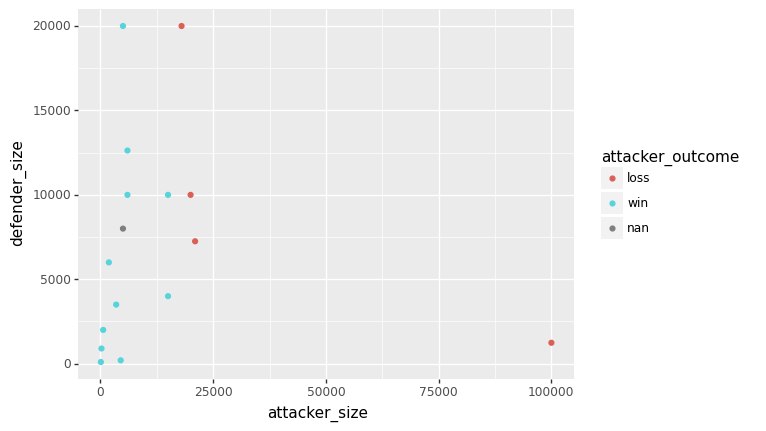

<ggplot: (140182181214)>

In [10]:
p = ggplot(battles, aes(x='attacker_size', y='defender_size', colour='attacker_outcome')) + \
    geom_point()
p

## How often were there more than one major houses on the attacking side?
The **value_counts()** function is used to count the occurrences of each unique value in the **attacker_count** column, and the **sort_index()** function is used to sort the resulting series by the index (i.e., the number of major attacker houses). The resulting series is then plotted as a bar chart using the **plot.bar()** function, with the rot parameter set to 0 to keep the x-axis labels horizontal. The x and y axis labels are then set using the **set()** function.

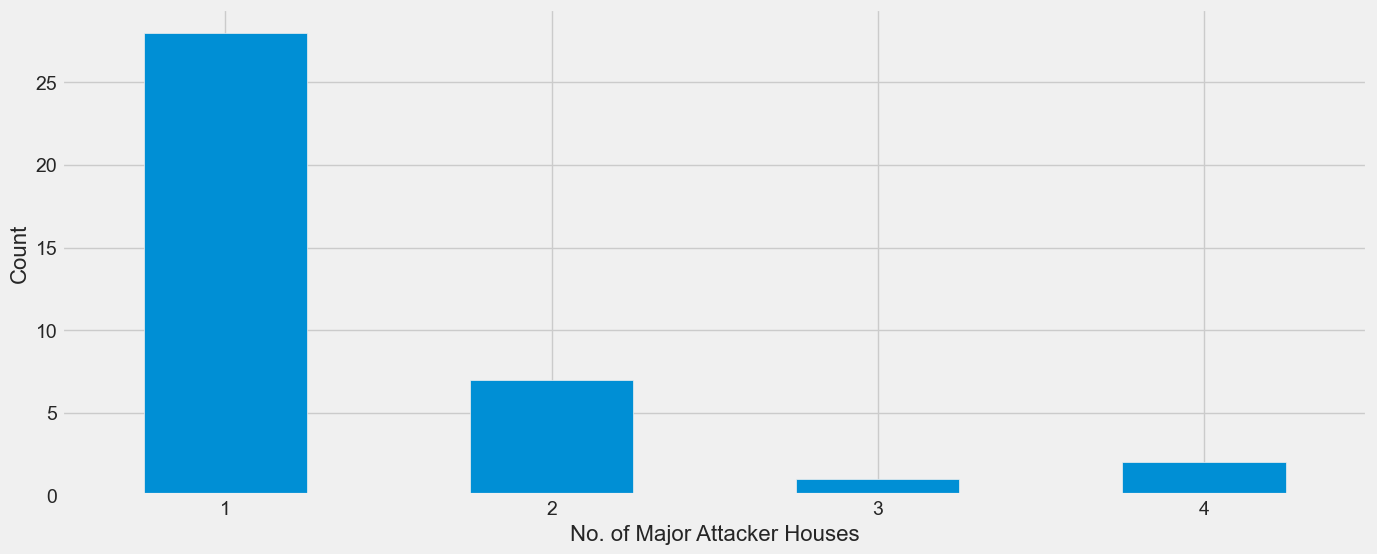

In [11]:
p = battles.attacker_count.value_counts().sort_index().plot.bar(rot = 0)
_ = p.set(xlabel = "No. of Major Attacker Houses", ylabel = "Count")

## Which pairs fought the most battles?
The **Counter** function is being used to count the number of occurrences of each unique pair of kings in the battles data, after removing battles where either the attacker king or the defender king is missing.

The **list** function is being used to convert the output of Counter into a list of tuples, which can then be sorted and plotted using pandas.

The resulting plot shows each pair of kings on the y-axis, with the number of battles fought between them on the x-axis. The y-axis labels are generated using a list comprehension that formats each pair of kings as a string in the form **"king1 vs. king2"**.

The **xlabel** argument is used to label the x-axis as **"No. of Battles"**, and the legend function is being used to remove the legend from the plot.

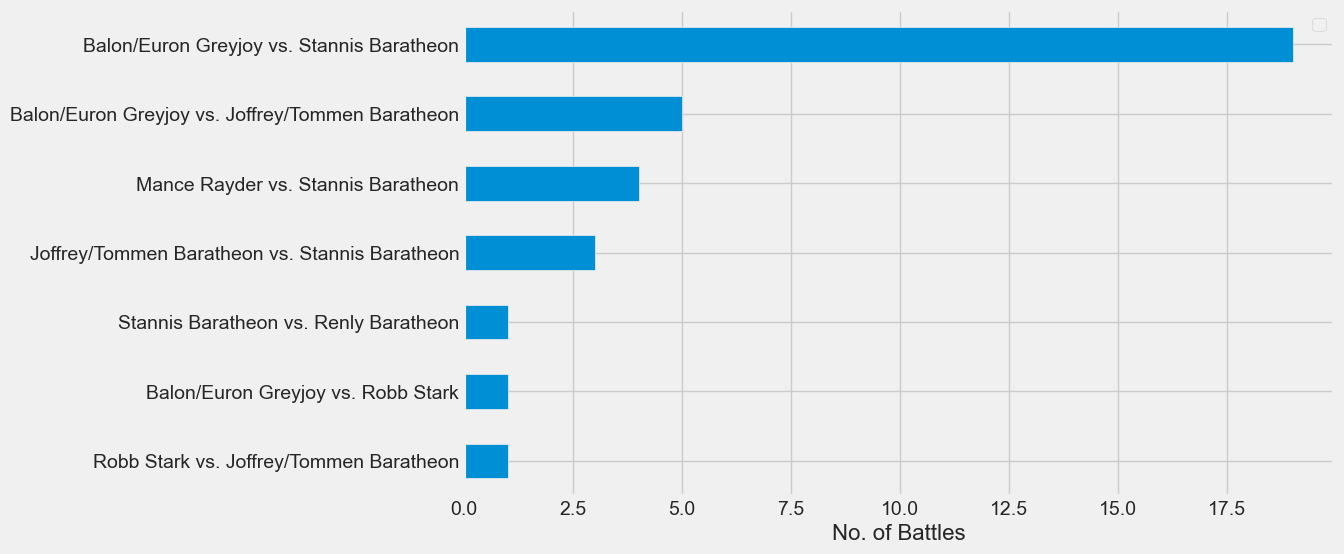

In [12]:
c = list(Counter([tuple(set(x)) for x in battles.dropna(subset = ["attacker_king", "defender_king"])[["attacker_king", "defender_king"]].values if len(set(x)) > 1]).items())
p = pd.DataFrame(c).sort_values(1).plot.barh(figsize = (10, 6))
_ = p.set(yticklabels = ["%s vs. %s" % (x[0], x[1]) for x in list(zip(*c))[0]], xlabel = "No. of Battles"), p.legend("")

## How many commanders did armies of different kings have?
The sns.boxplot function is being used with the following arguments:

- **"att_comm_count"**: the name of the column in the battles dataframe that contains the number of attacker commanders.
- **"attacker_king"**: the name of the column in the battles dataframe that contains the name of the attacker king.
- **saturation = .6**: a value between 0 and 1 that controls the saturation of the colors used for the plot.
- **fliersize = 10.**: the size of the outliers markers in the plot.
- **palette = ["lightgray", sns.color_palette()[1], "grey", "darkblue"]**: a list of colors to be used for each attacker king in the plot.


The resulting plot shows a box for each attacker king, with the bottom of the box indicating the **25th percentile**, the line inside the box indicating the median, and the top of the box indicating the **75th percentile** of the distribution of the number of attacker commanders. The **whiskers** extend to the most extreme data points within **1.5 times the interquartile range (IQR)** of the distribution, and any data points beyond the whiskers are plotted as individual points (outliers).

The xlabel argument is used to label the x-axis as "No. of Attacker Commanders", the ylabel argument is used to label the y-axis as "Attacker King", and the xticks argument is used to set the x-axis tick marks to range from 0 to 7.

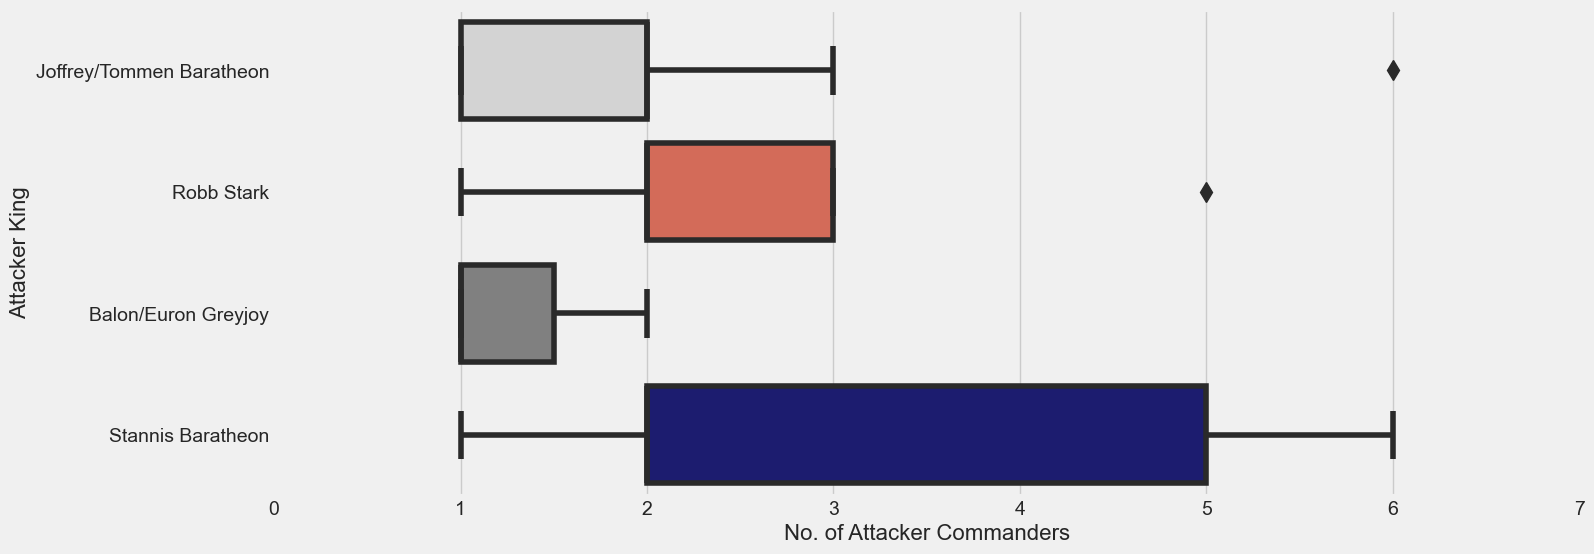

In [13]:
p = sns.boxplot("att_comm_count", "attacker_king", data = battles, saturation = .6, fliersize = 10., palette = ["lightgray", sns.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "No. of Attacker Commanders", ylabel = "Attacker King", xticks = range(8))

## How many major death/capture events occur in each region?
The **groupby** function is being used to group the battles data by region, and then the **sum** function is being used to sum the number of major deaths and major captures for each region.

The resulting data dataframe contains the total number of major deaths and major captures for each region.

The **pd.concat** function is being used to **concatenate** the data dataframe with another dataframe that contains the number of battles in each region, as counted using the value_counts function on the region column of the battles dataframe. The resulting dataframe is sorted in descending order by region name.

The **plot.bar** function is being used to generate a bar plot of the resulting dataframe, with each region represented as a group of three bars (one for major deaths, one for major captures, and one for the number of battles). The bars are colored using a list of colors, and the rot argument is used to rotate the x-axis labels to avoid overlap.

The xlabel argument is used to label the x-axis as "Region", the ylabel argument is used to label the y-axis as "No. of Events", and the legend function is being used to add a legend to the plot with labels for each group of bars. The fontsize argument is used to set the font size for the legend labels.

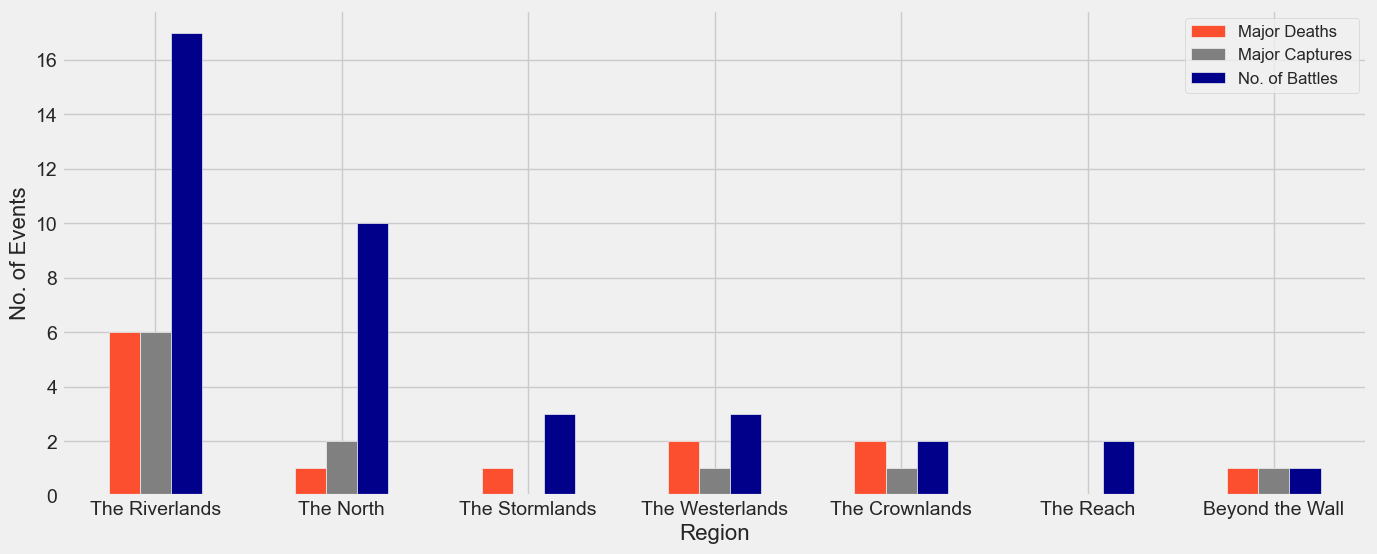

In [14]:
data = battles.groupby("region").sum()[["major_death", "major_capture"]]
p = pd.concat([data, battles.region.value_counts().to_frame()], axis = 1).sort_values("region", ascending = False).copy(deep = True).plot.bar(color = [sns.color_palette()[1], "grey", "darkblue"], rot = 0)
_ = p.set(xlabel = "Region", ylabel = "No. of Events"), p.legend(["Major Deaths", "Major Captures", "No. of Battles"], fontsize = 12.)

## Is there a relationship between survival and having dead relations?
The code is creating a **stacked horizontal** bar chart using pandas to show the proportion of dead and alive characters in the character_predictions dataframe based on whether or not they have dead relations.

The **groupby** function is being used to group the character_predictions dataframe by two columns: **boolDeadRelations** (which is a boolean column indicating whether or not the character has dead relations) and **isAlive** (which is a boolean column indicating whether or not the character is alive). The **count** function is then being used to count the number of instances in each group for the S.No column. The resulting series is then being unstacked to create a dataframe where the index is the boolDeadRelations column and the columns are the isAlive column.

The resulting data dataframe contains the count of characters in each group.

The **div** function is being used to divide the values in the data dataframe by the sum of each row. This creates a new dataframe with the proportion of characters in each group that are dead or alive.

The **plot.barh** function is being used to create a stacked horizontal bar chart of the resulting dataframe, where each bar represents the proportion of dead and alive characters for each group. The stacked argument is set to True to stack the bars on top of each other, and the width argument is set to .5 to control the width of the bars.

The **set_xlim** function is used to set the x-axis limits to be between 0 and 1, while the set function is being used to set the y-axis labels to "No" and "Yes", and to remove the x-axis labels. The xlabel argument is being used to label the x-axis as "Proportion of Dead vs. Alive", and the ylabel argument is being used to label the y-axis as "Has Dead Relations". The legend function is being used to add a legend to the plot with labels for the "Dead" and "Alive" bars.

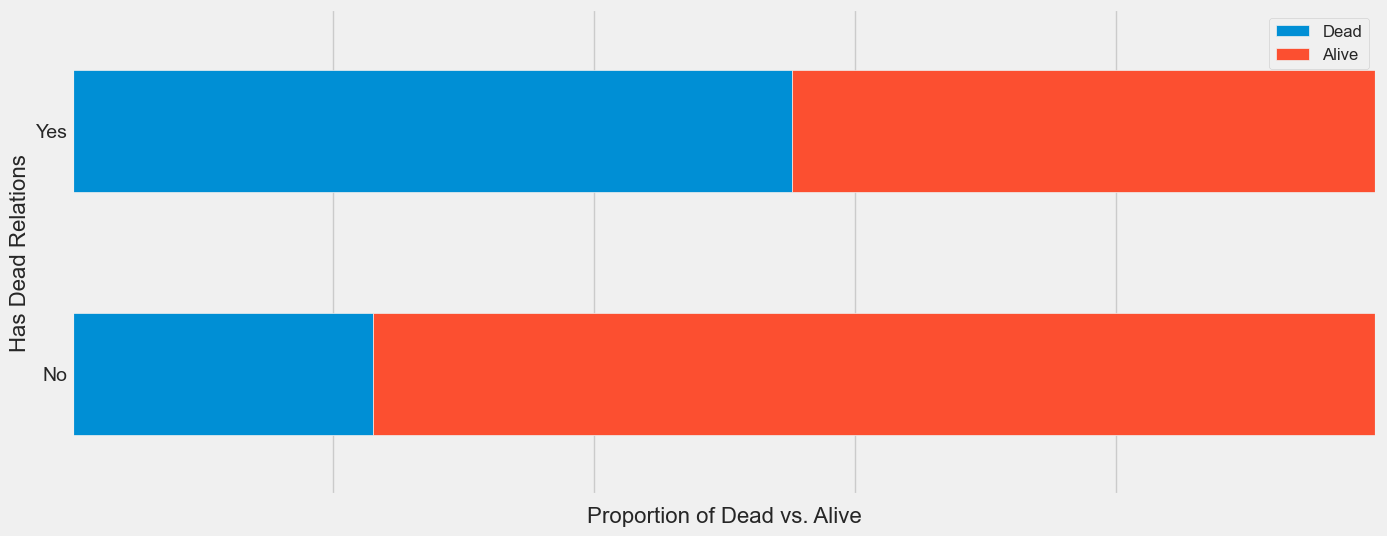

In [15]:
data = character_predictions.groupby(["boolDeadRelations", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, width = .5)
_ = p.set_xlim([0, 1]), p.set(yticklabels = ["No", "Yes"], xticklabels = "", xlabel = "Proportion of Dead vs. Alive", ylabel = "Has Dead Relations"), p.legend(["Dead", "Alive"])

## How does appearing in more books relate to survival?

**data = character_predictions.groupby(["no_of_books", "isAlive"]).count()["S.No"].unstack().copy(deep = True)**: This line groups the data in character_predictions by the number of books a character has appeared in (no_of_books) and whether they are alive or not (isAlive). It then counts the number of entries in each group and returns a table with the count for each group, with the number of books as the row index and the alive/dead status as the column index. The **unstack()** function pivots the table so that the alive/dead status becomes a separate column instead of a column index. Finally, the **copy(deep = True)** function creates a deep copy of the resulting table to avoid modifying the original data.

**p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 8), width = .5)**: This line normalizes the count data in data to show the proportion of dead vs. alive characters for each number of books. The **div()** function divides each row by the sum of its values to get the proportion, and the **plot.barh()** function creates a horizontal stacked bar chart of the resulting data. The **rot = 0** argument sets the x-axis labels to be horizontal, the figsize argument sets the size of the figure, and the width argument sets the width of the bars.

**_ = p.set(xticklabels = "", xlim = [0, 1], ylabel = "No. of Books", xlabel = "Proportion of Dead vs. Alive"), p.legend(["Dead", "Alive"], loc = "upper right", ncol = 2, borderpad = -.15**): This line sets some additional parameters for the plot. The set() function sets the x-axis tick labels to be blank (represented by an empty string ""), sets the x-axis limits to be between 0 and 1 (the range of proportions), sets the y-axis label to "No. of Books", and sets the x-axis label to "Proportion of Dead vs. Alive". The legend() function adds a legend to the plot with the labels "Dead" and "Alive" (corresponding to the two colors used in the plot) and sets its location to the "upper right" corner, with two columns and a negative border pad to reduce the spacing between the legend items. The _ = at the beginning of the line suppresses the output of the set() function (which is not needed) and assigns the plot object to the variable p.

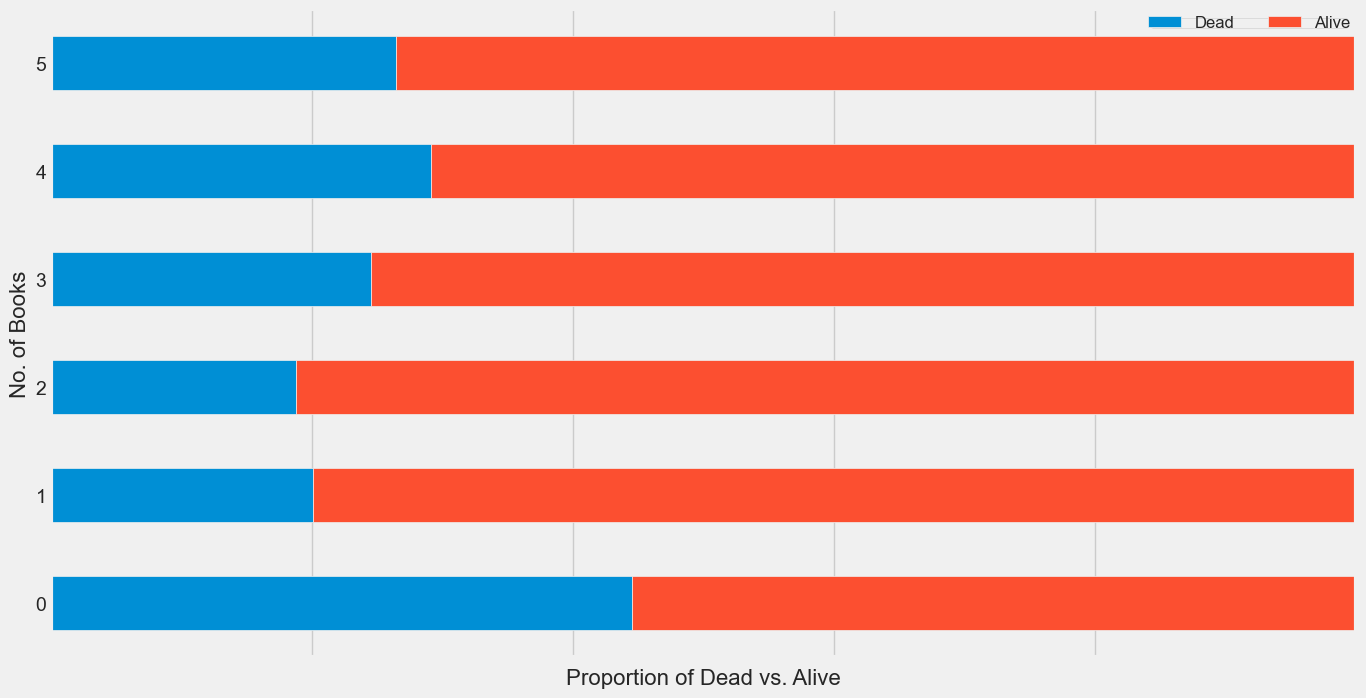

In [16]:
data = character_predictions.groupby(["no_of_books", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 8), width = .5)
_ = p.set(xticklabels = "", xlim = [0, 1], ylabel = "No. of Books", xlabel = "Proportion of Dead vs. Alive"), p.legend(["Dead", "Alive"], loc = "upper right", ncol = 2, borderpad = -.15)

## How does culture relate to survival?
For this, we will rename cultures using (ahem) domain knowledge as many of the culture values map to a single culture.

In [17]:
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()

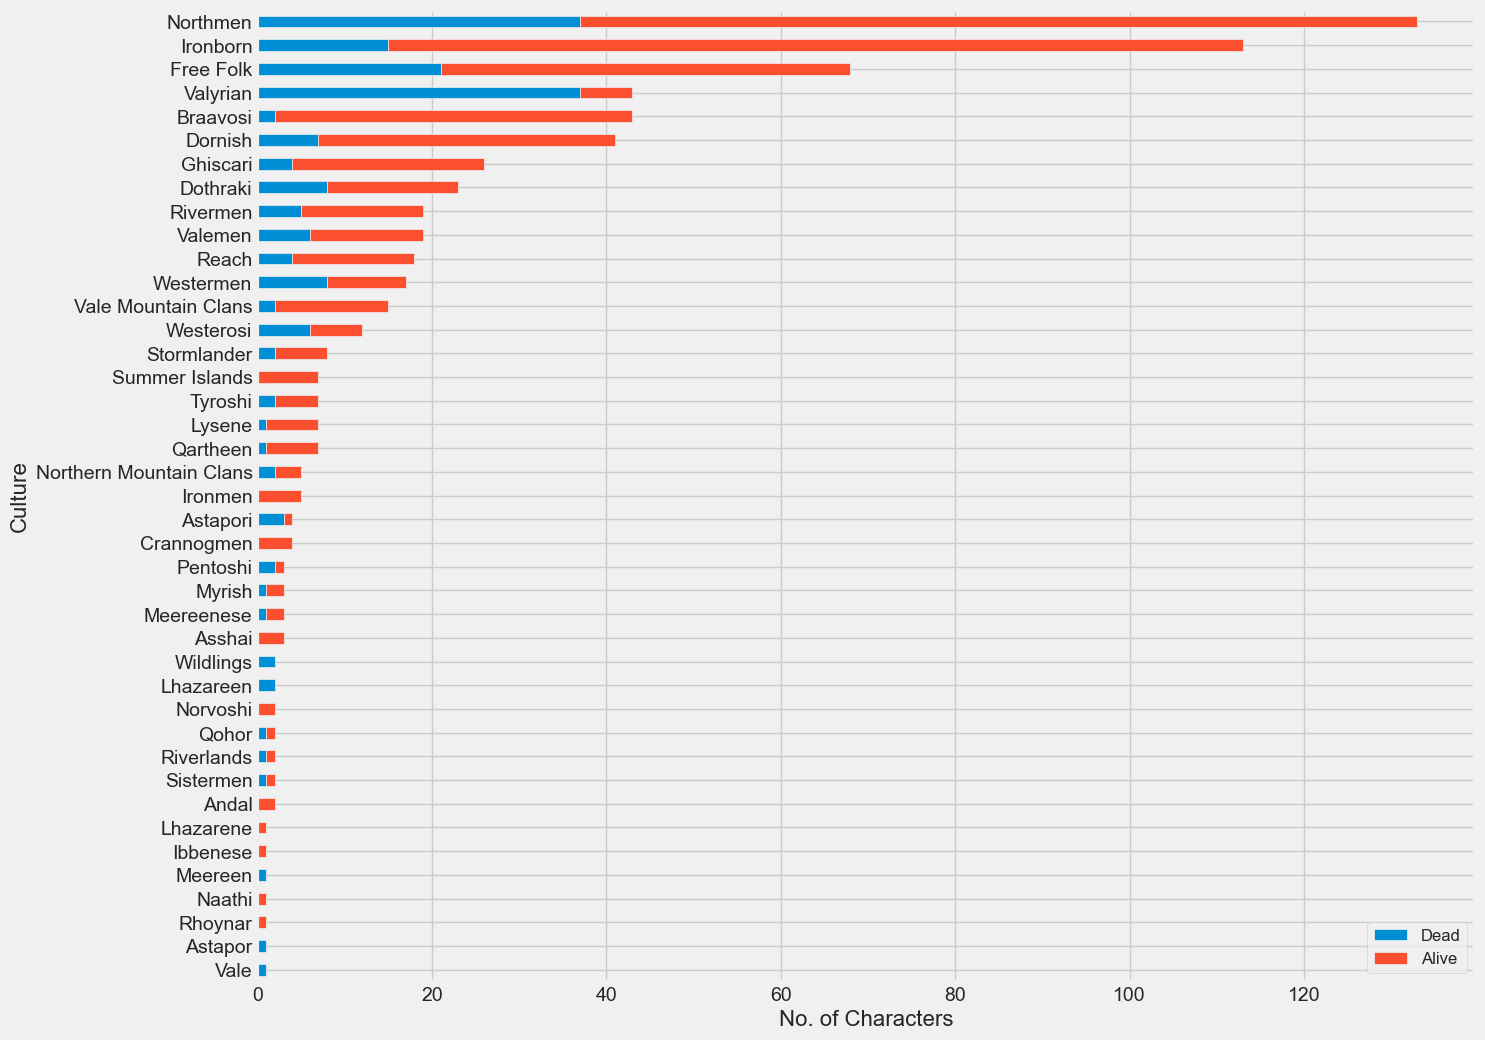

In [18]:
character_predictions.loc[:, "culture"] = [get_cult(x) for x in character_predictions.culture.fillna("")]
data = character_predictions.groupby(["culture", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
data.loc[:, "total"]= data.sum(axis = 1)
p = data[data.index != ""].sort_values("total")[[0, 1]].plot.barh(stacked = True, rot = 0, figsize = (14, 12),)
_ = p.set(xlabel = "No. of Characters", ylabel = "Culture"), p.legend(["Dead", "Alive"], loc = "lower right")

## Do larger armies necessarily win?
This code selects rows from a Pandas DataFrame called battles where both the "attacker_size" and "defender_size" columns are not NaN. The resulting DataFrame is called data.

The code then creates a new DataFrame by concatenating the difference between the attacker and defender sizes (i.e., data.attacker_size - data.defender_size) with the "attacker_outcome" column of the battles DataFrame. This new DataFrame is also called data.

Next, the code selects only rows where the difference in army size is not equal to zero (i.e., where there was an advantage in army size for one side).

Finally, the code generates a horizontal bar chart of the differences in army size, colored according to the "attacker_outcome" column. The x-axis represents the difference in army size, while the y-axis represents the name of each battle. The chart also includes a vertical line at 0 to indicate where the army sizes were equal. The legend shows the colors for "Victory" and "Loss" outcomes.

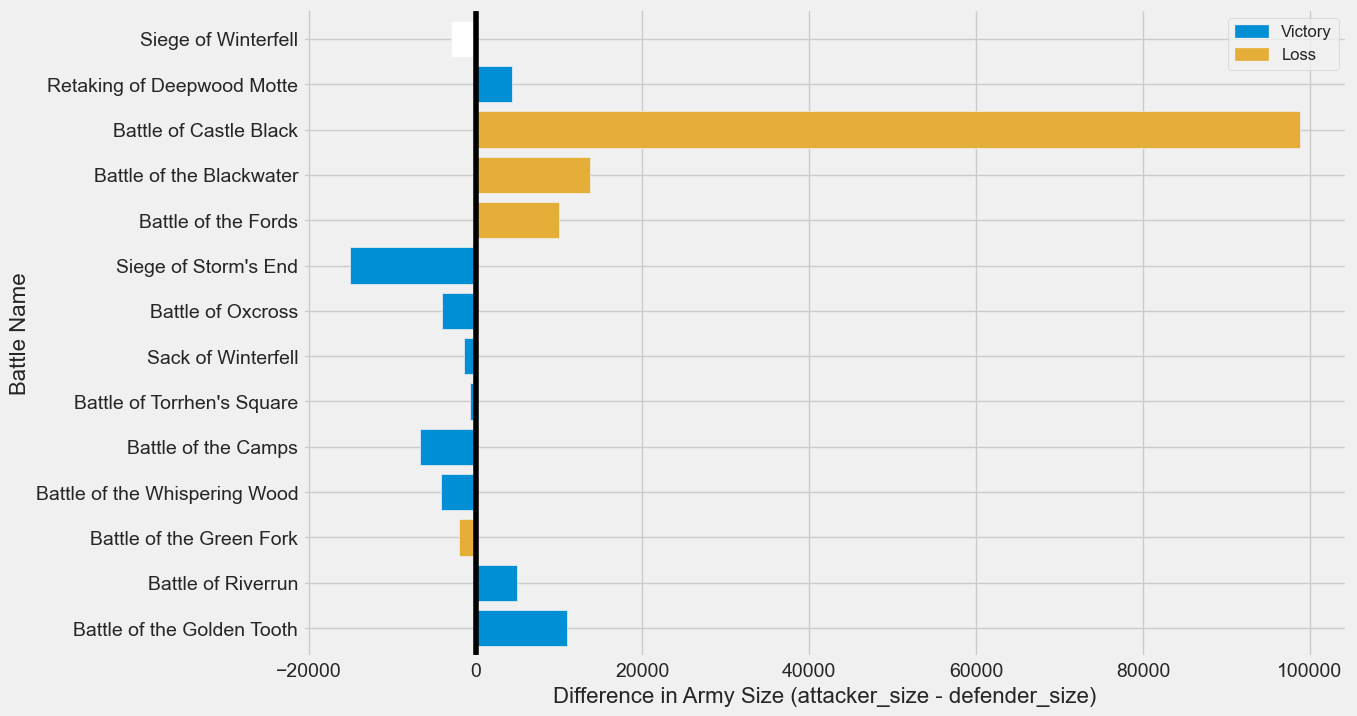

In [19]:
data = battles.dropna(subset = ["attacker_size", "defender_size"]).copy(deep = True)
data = pd.concat([(data.attacker_size - data.defender_size).to_frame(), battles[["attacker_outcome"]]], axis = 1, join = "inner")
data = data[data[0] != 0]
p = data[0].plot.barh(figsize = (12, 8), width = .8, color = [sns.color_palette()[0] if x == "win" else sns.color_palette()[2] if x == "loss" else "white" for x in data.attacker_outcome.values])
_ = p.legend(handles = [mpatches.Patch(color = sns.color_palette()[0], label = "Victory", aa = True), mpatches.Patch(color = sns.color_palette()[2], label = "Loss", aa = True)])
_ = p.axvline(0, color = 'k'), p.set(yticklabels = battles.name.iloc[data.index].values, xlabel = "Difference in Army Size (attacker_size - defender_size)", ylabel = "Battle Name")

This code is creating a **correlation matrix** of the data frame using the **corr() function**, and then styling the resulting matrix using the **style.background_gradient()** method to apply a gradient color map ('**Reds**') to the values in the matrix. The correlation matrix shows the correlation coefficients between each pair of variables in the data frame, where a coefficient of **1** represents a perfect positive correlation, **0** represents no correlation, and **-1** represents a perfect negative correlation. The color gradient applied by background_gradient() allows for a visual representation of the strength and direction of the correlations, with darker colors representing stronger correlations and lighter colors representing weaker correlations.

In [20]:
battles.corr().style.background_gradient(cmap='Reds')

,year,battle_number,defender_3,defender_4,major_death,major_capture,attacker_size,defender_size,summer,defender_count,attacker_count,att_comm_count
year,1.000000,0.906781,nan,nan,-0.341050,-0.166234,0.155841,-0.366048,-0.841912,0.123752,0.318788,-0.012370
battle_number,0.906781,1.000000,nan,nan,-0.270421,-0.105225,0.086418,-0.297730,-0.799090,0.141547,0.337188,0.027313
defender_3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
defender_4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
major_death,-0.341050,-0.270421,nan,nan,1.000000,0.264464,0.267966,0.081815,0.337136,0.243505,0.153054,0.302054
major_capture,-0.166234,-0.105225,nan,nan,0.264464,1.000000,0.331961,0.249510,0.142112,0.254333,0.217990,0.283342
attacker_size,0.155841,0.086418,nan,nan,0.267966,0.331961,1.000000,-0.112118,-0.273054,0.646230,0.236363,0.537062
defender_size,-0.366048,-0.297730,nan,nan,0.081815,0.249510,-0.112118,1.000000,0.347108,-0.102356,-0.198976,0.257988
summer,-0.841912,-0.799090,nan,nan,0.337136,0.142112,-0.273054,0.347108,1.000000,-0.146587,-0.416268,0.023105
defender_count,0.123752,0.141547,nan,nan,0.243505,0.254333,0.646230,-0.102356,-0.146587,1.000000,0.555903,0.201087


This code creates a **heatmap** using the **heatmap()** function from the Seaborn library to visualize the correlation matrix of the battles DataFrame.

The **annot** parameter is set to True to display the correlation coefficients in each cell of the heatmap.

The **figsize** parameter is used to set the size of the figure.

The output is a color-coded matrix where darker colors indicate stronger positive or negative correlations between the variables. The diagonal of the matrix is always shown in dark red since it represents the correlation between each variable and itself, which is always perfect.

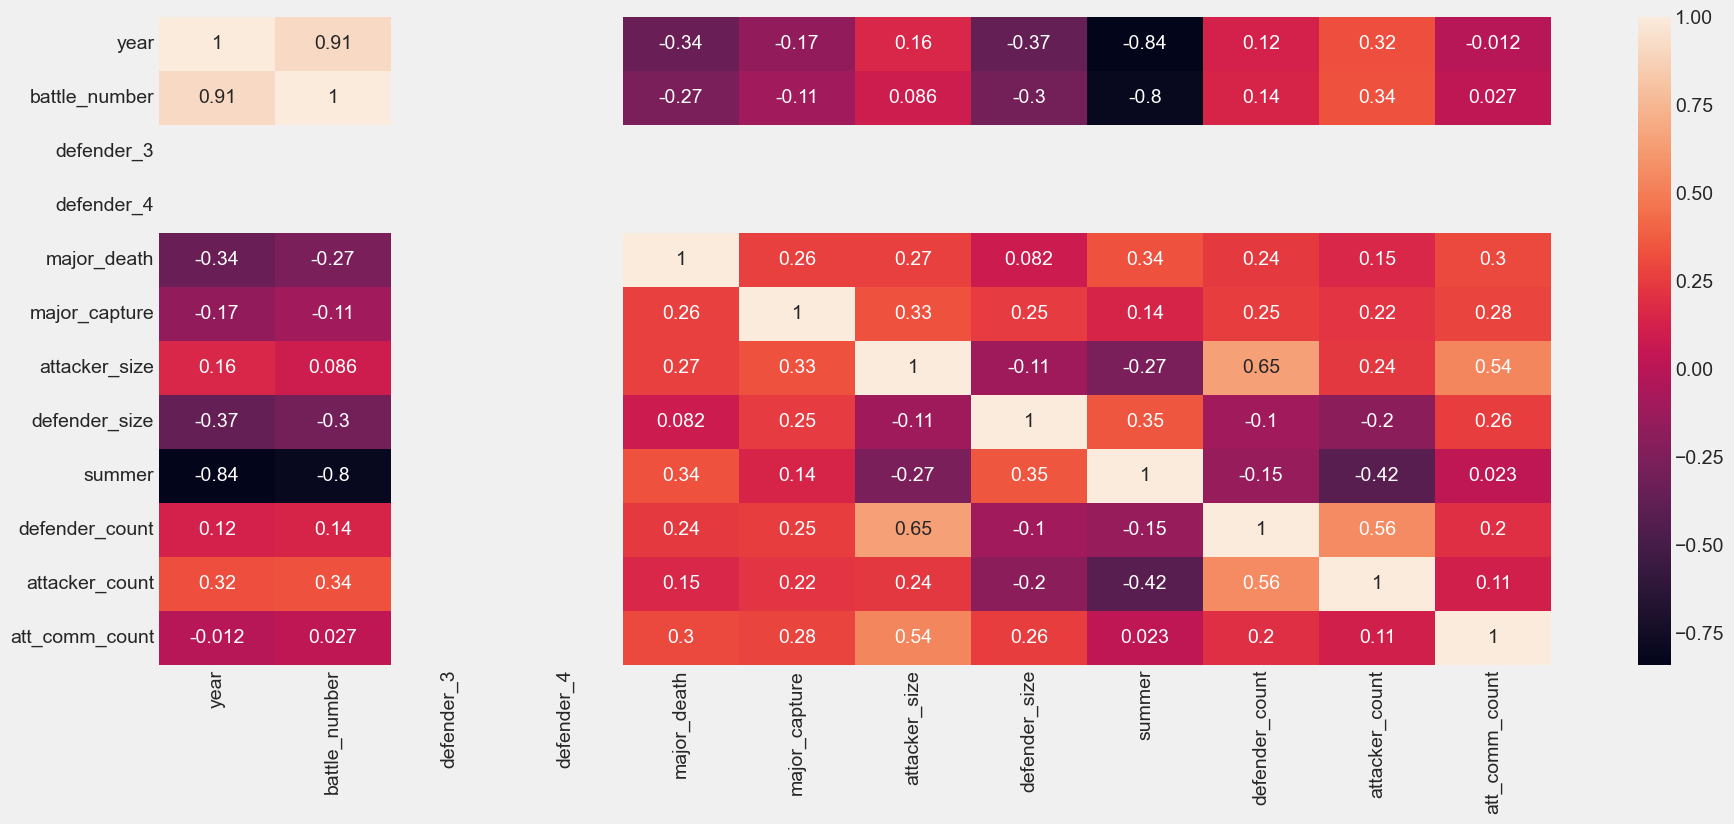

In [21]:
fig,ax=plt.subplots(figsize=(20,8))
sns.heatmap(battles.corr(),annot=True);

This code creates a **horizontal bar chart** using matplotlib library.

First, the battles dataframe is grouped by year and the sum of each numerical column is calculated. The resulting dataframe is saved as **bpy**.

Then, the bar chart is created with **plt.barh()** function. The x-axis represents the count of battles **(bpy['battle_number'])** and y-axis represents the year **(bpy['year'])**. The **plt.xticks()** function is used to rotate the x-axis labels by 90 degrees.

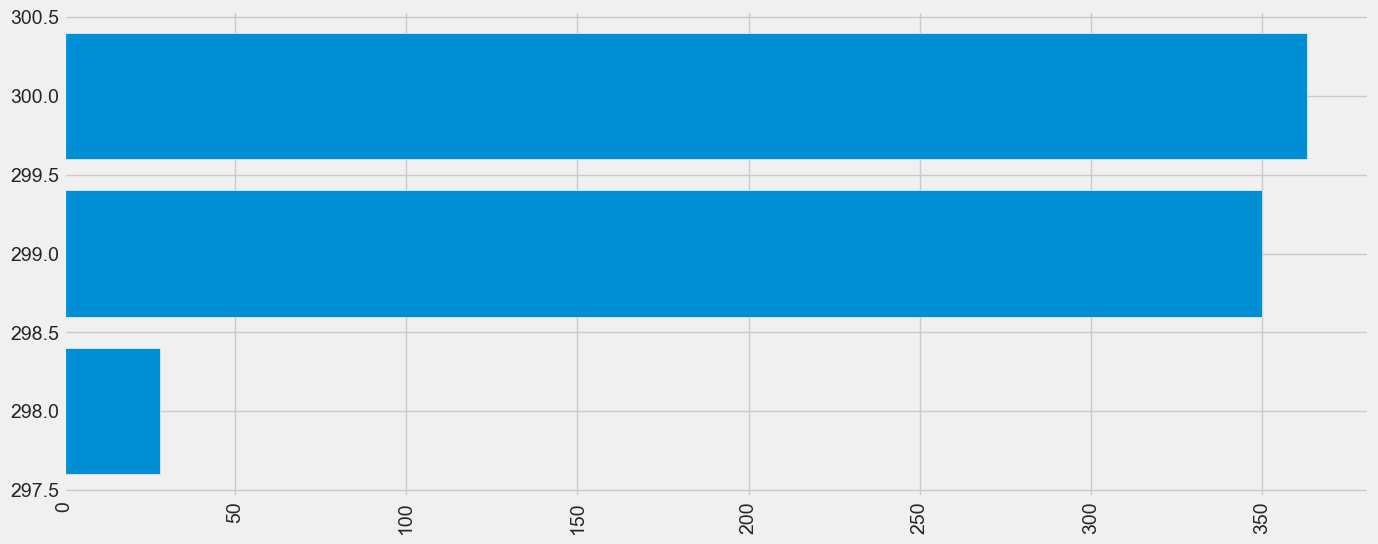

In [22]:
bpy=battles.groupby('year',as_index=False).sum()
plt.barh(bpy['year'],bpy['battle_number'])
plt.xticks(rotation=90);

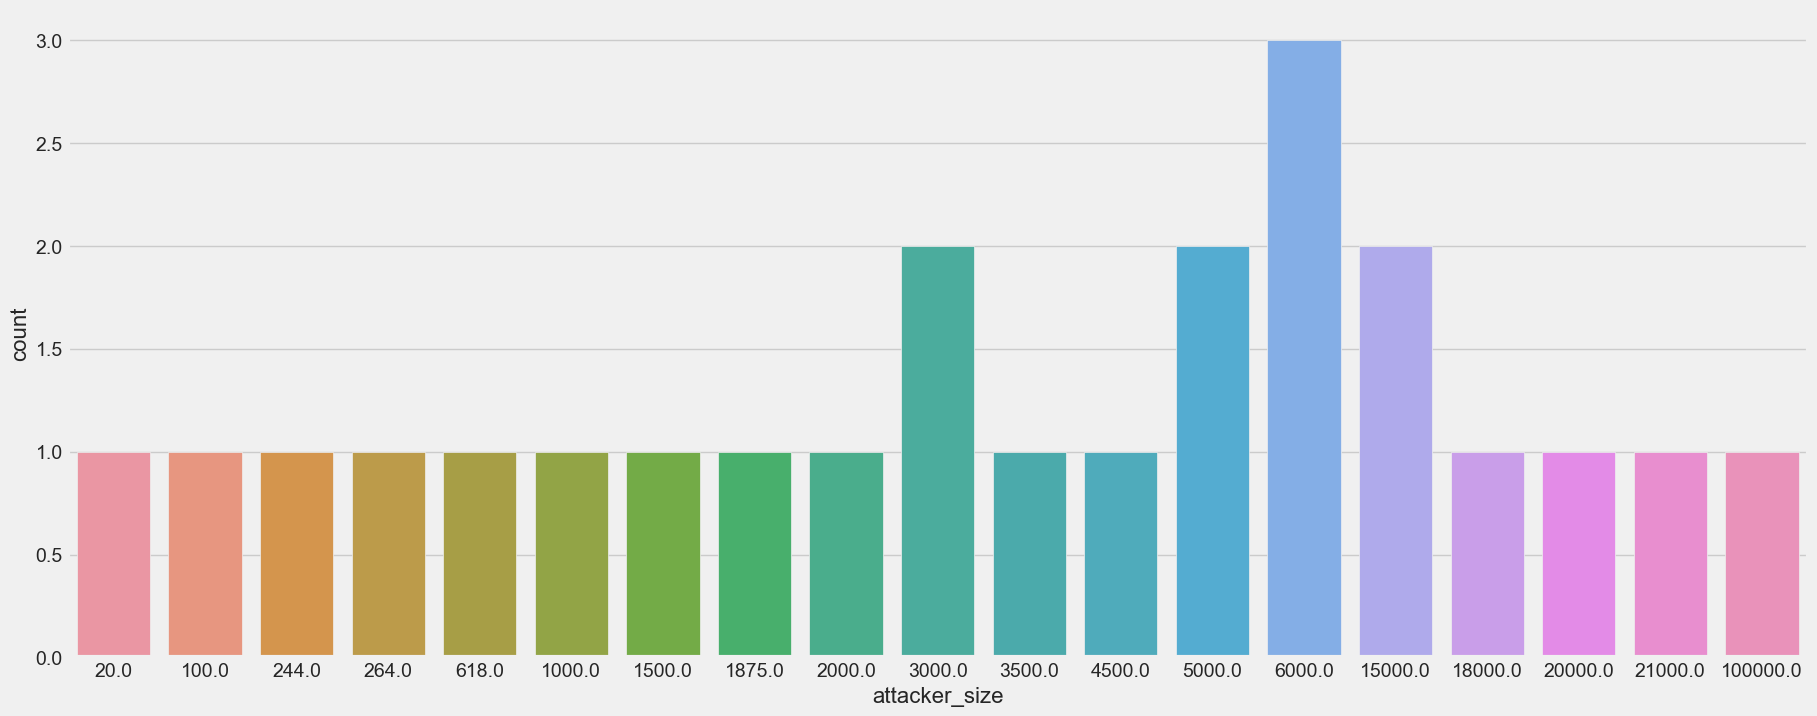

In [23]:
#attacker size count.
plt.figure(figsize=(20,8))
sns.countplot(battles['attacker_size']);

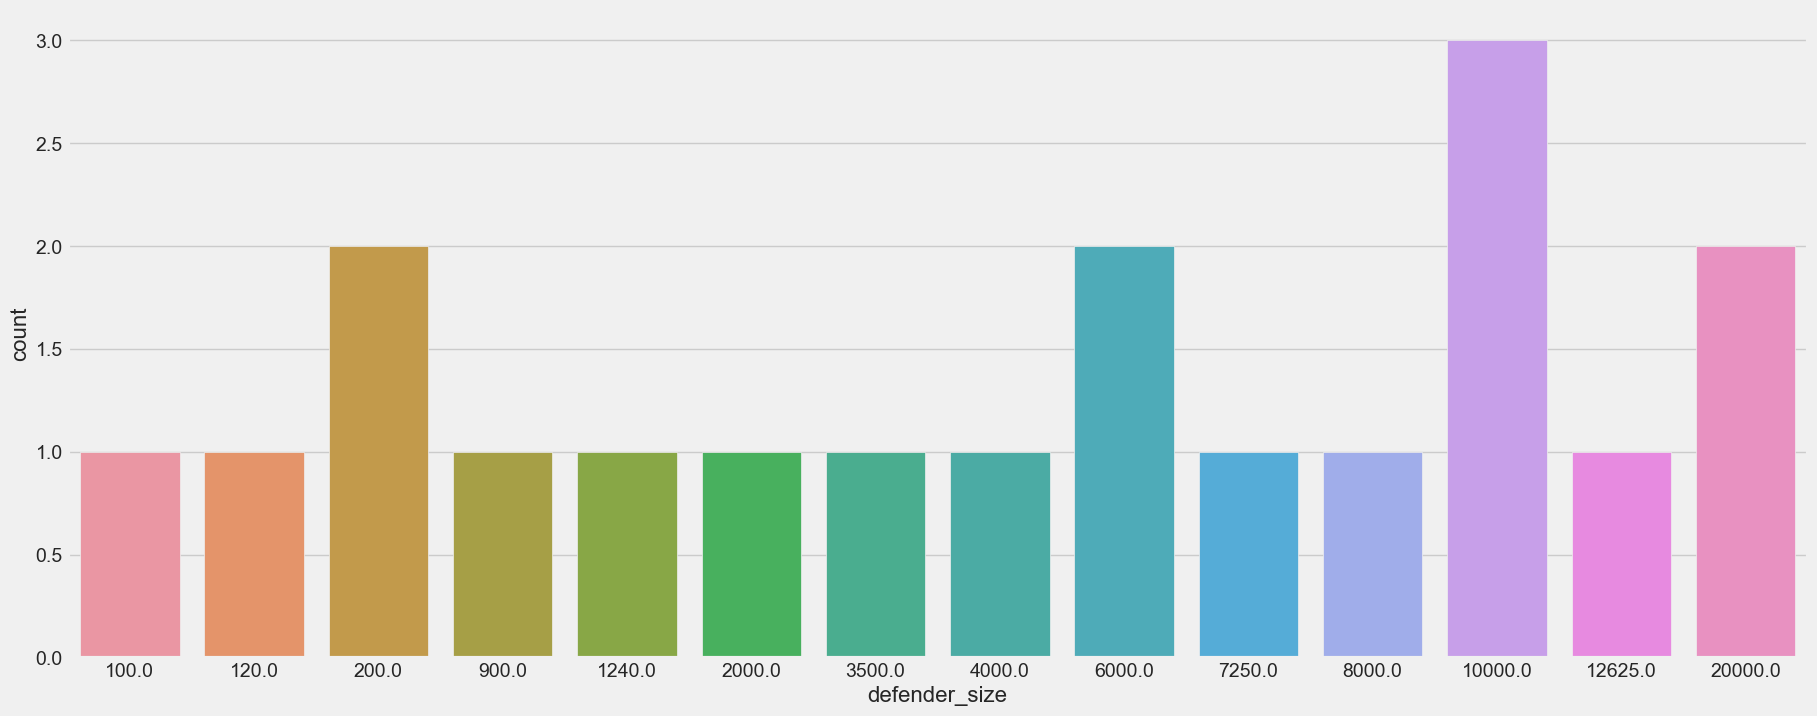

In [24]:
plt.figure(figsize=(20,8))
sns.countplot(battles['defender_size']);

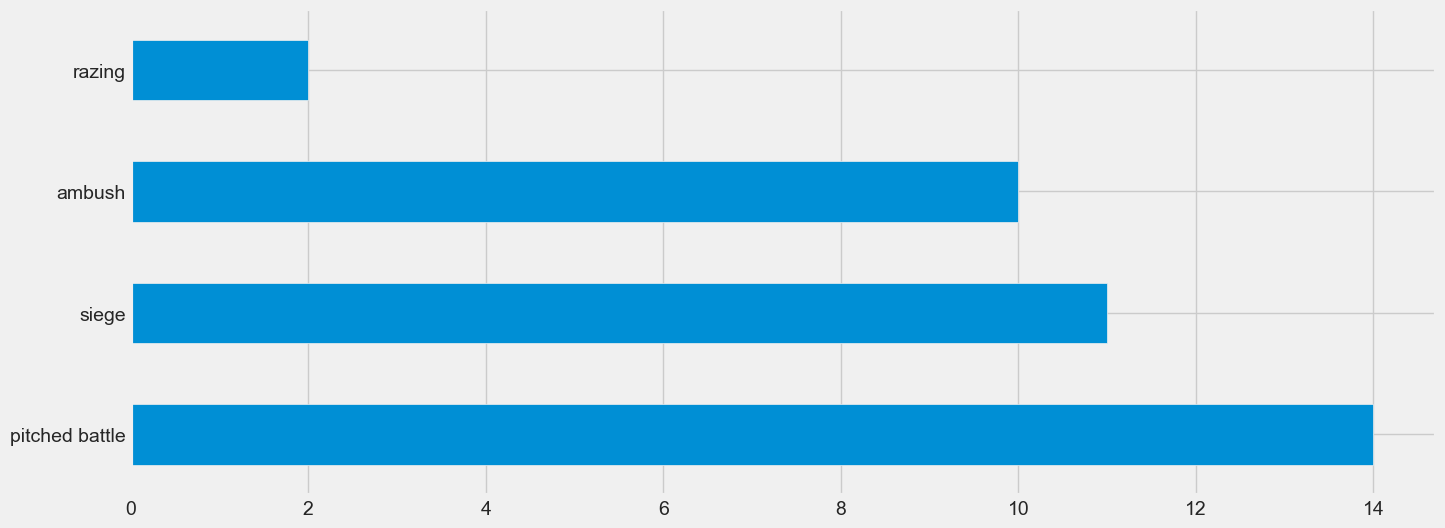

In [25]:
battles['battle_type'].value_counts().plot(kind = 'barh');

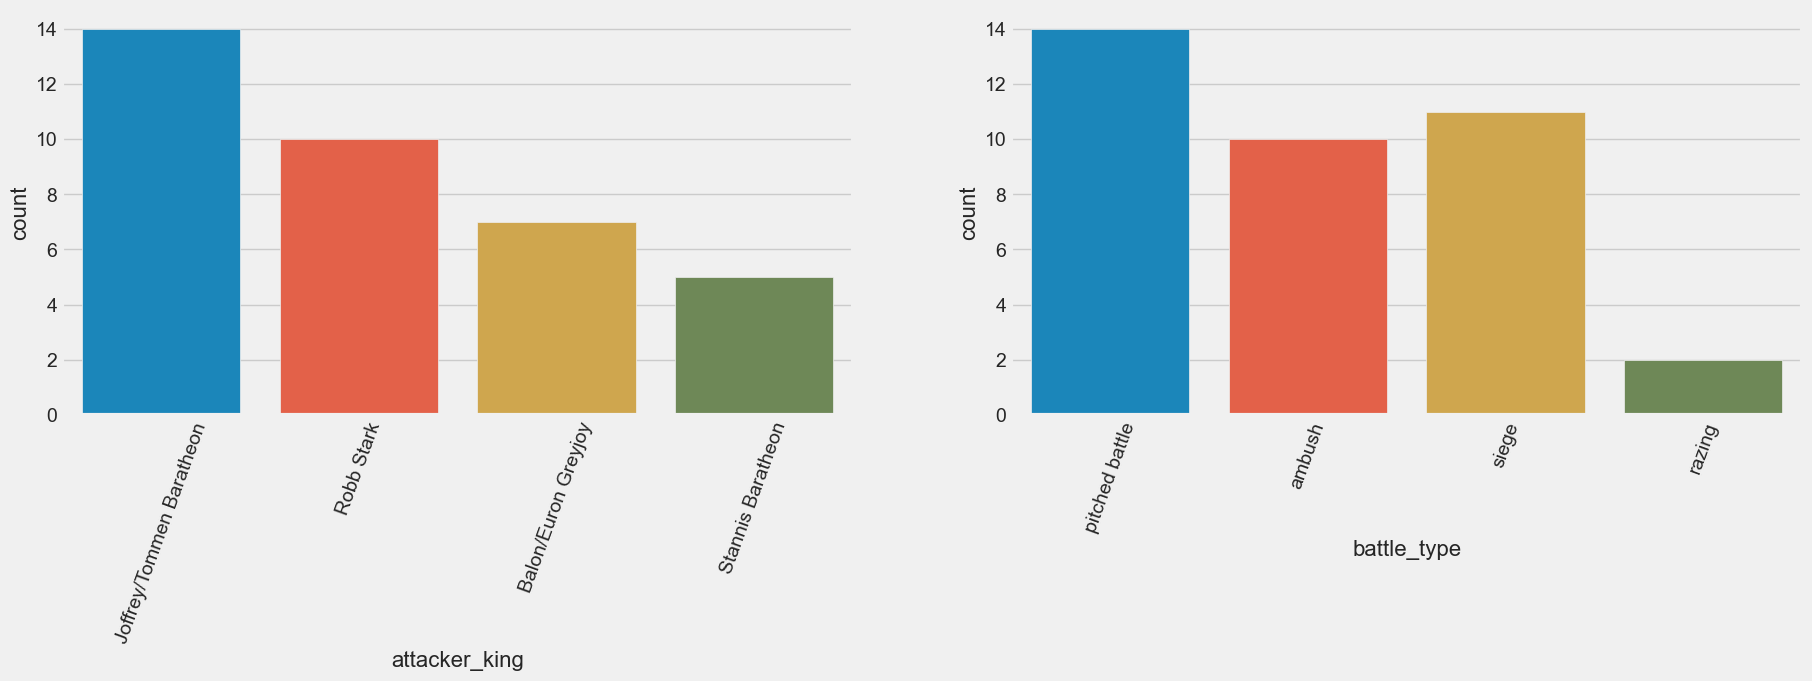

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(battles['attacker_king'])
plt.xticks(rotation=70)
plt.subplot(1,2,2)
sns.countplot(battles['battle_type']);
plt.xticks(rotation=70);

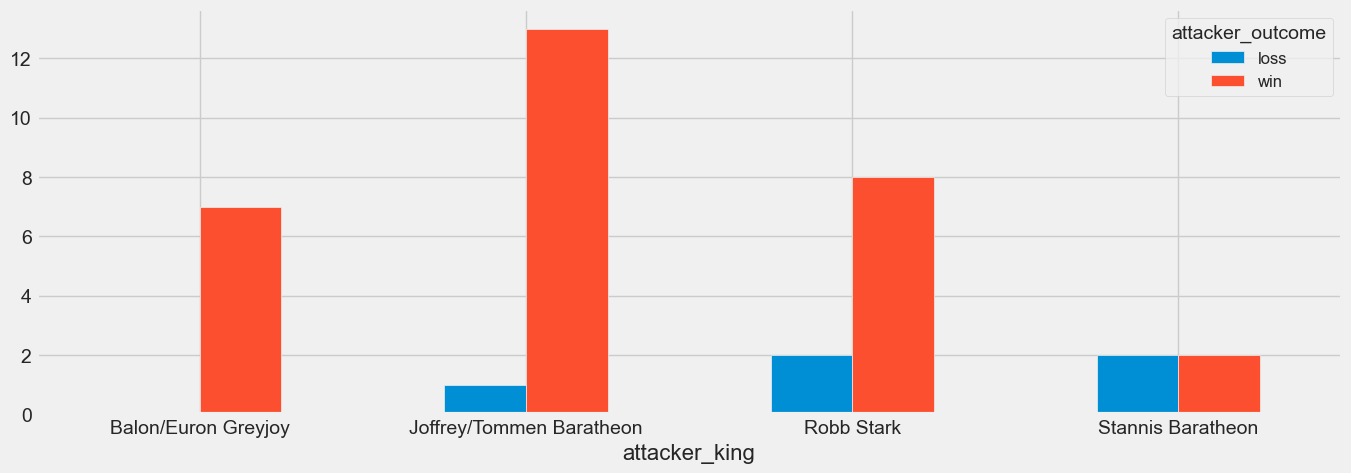

In [27]:
pd.crosstab(battles['attacker_king'],battles['attacker_outcome']).plot(kind='bar',figsize=(15,5));
plt.xticks(rotation='horizontal');

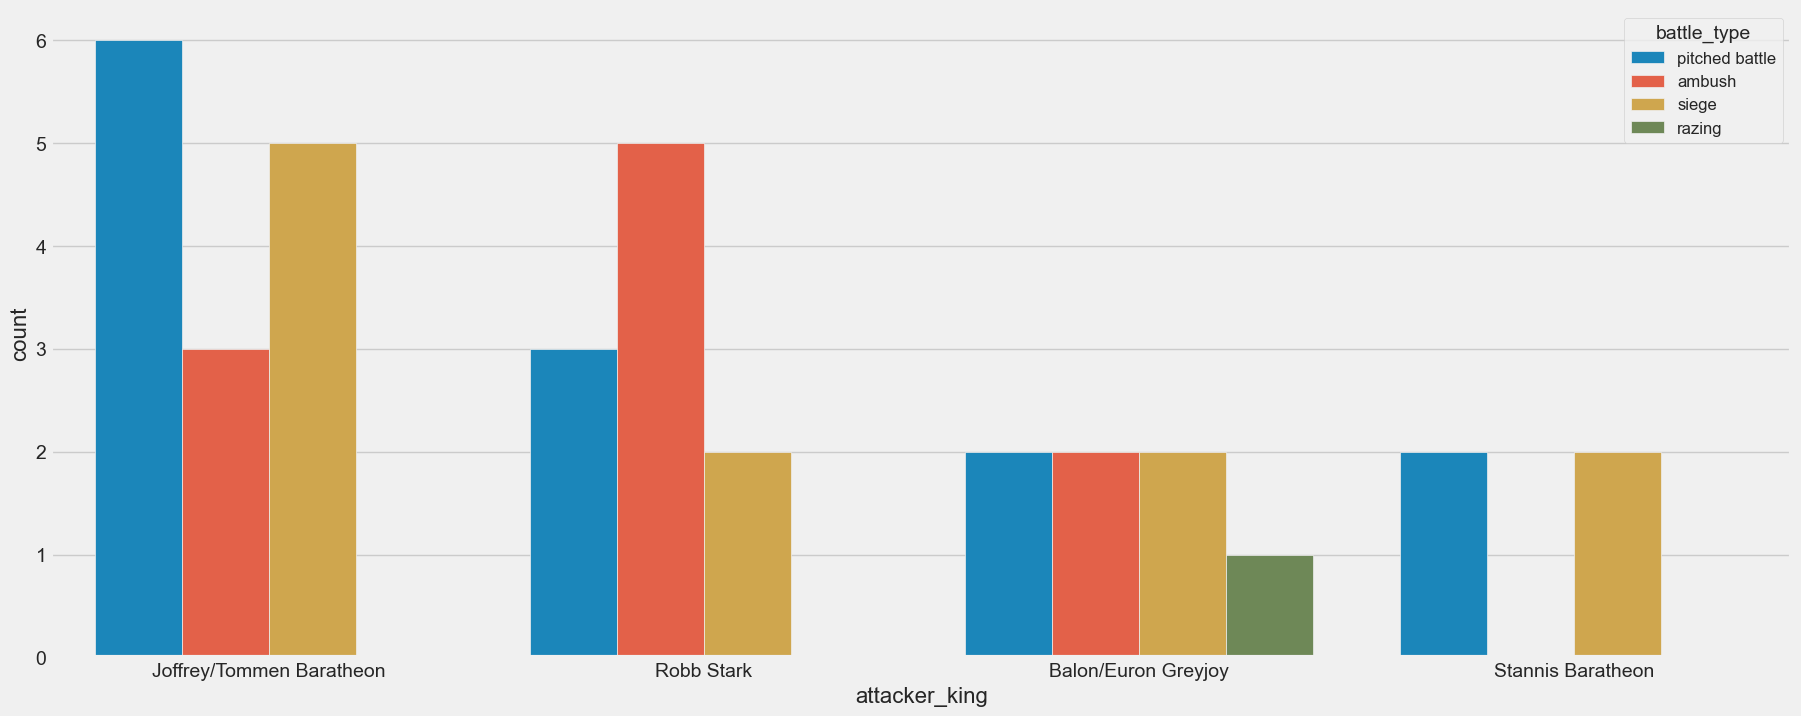

In [28]:
plt.figure(figsize=(20,8))
sns.countplot(battles['attacker_king'],hue=battles['battle_type']);

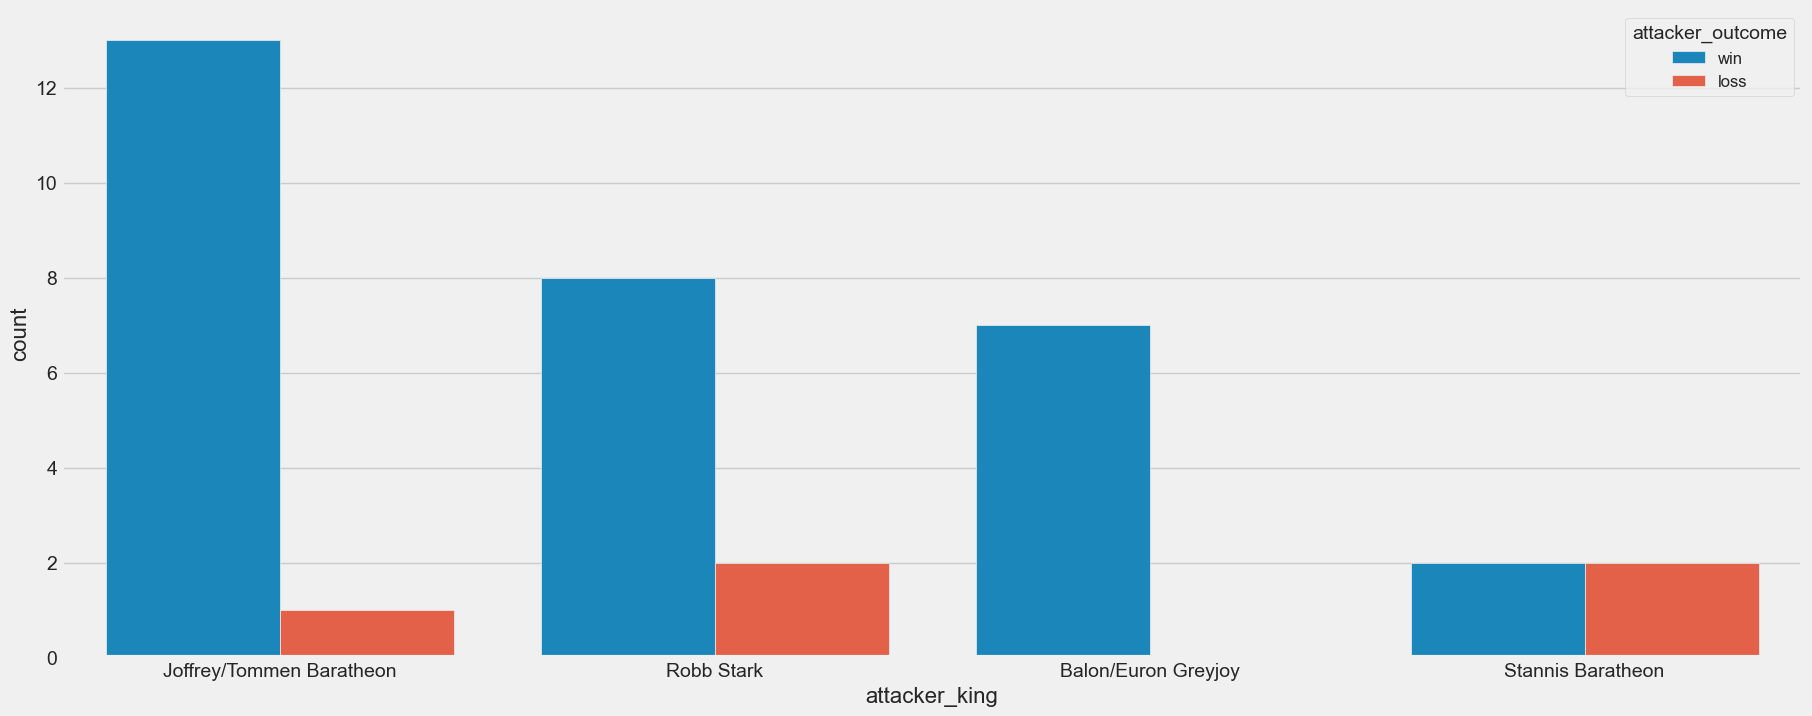

In [29]:
plt.figure(figsize=(20,8))
sns.countplot(battles['attacker_king'],hue=battles['attacker_outcome']);

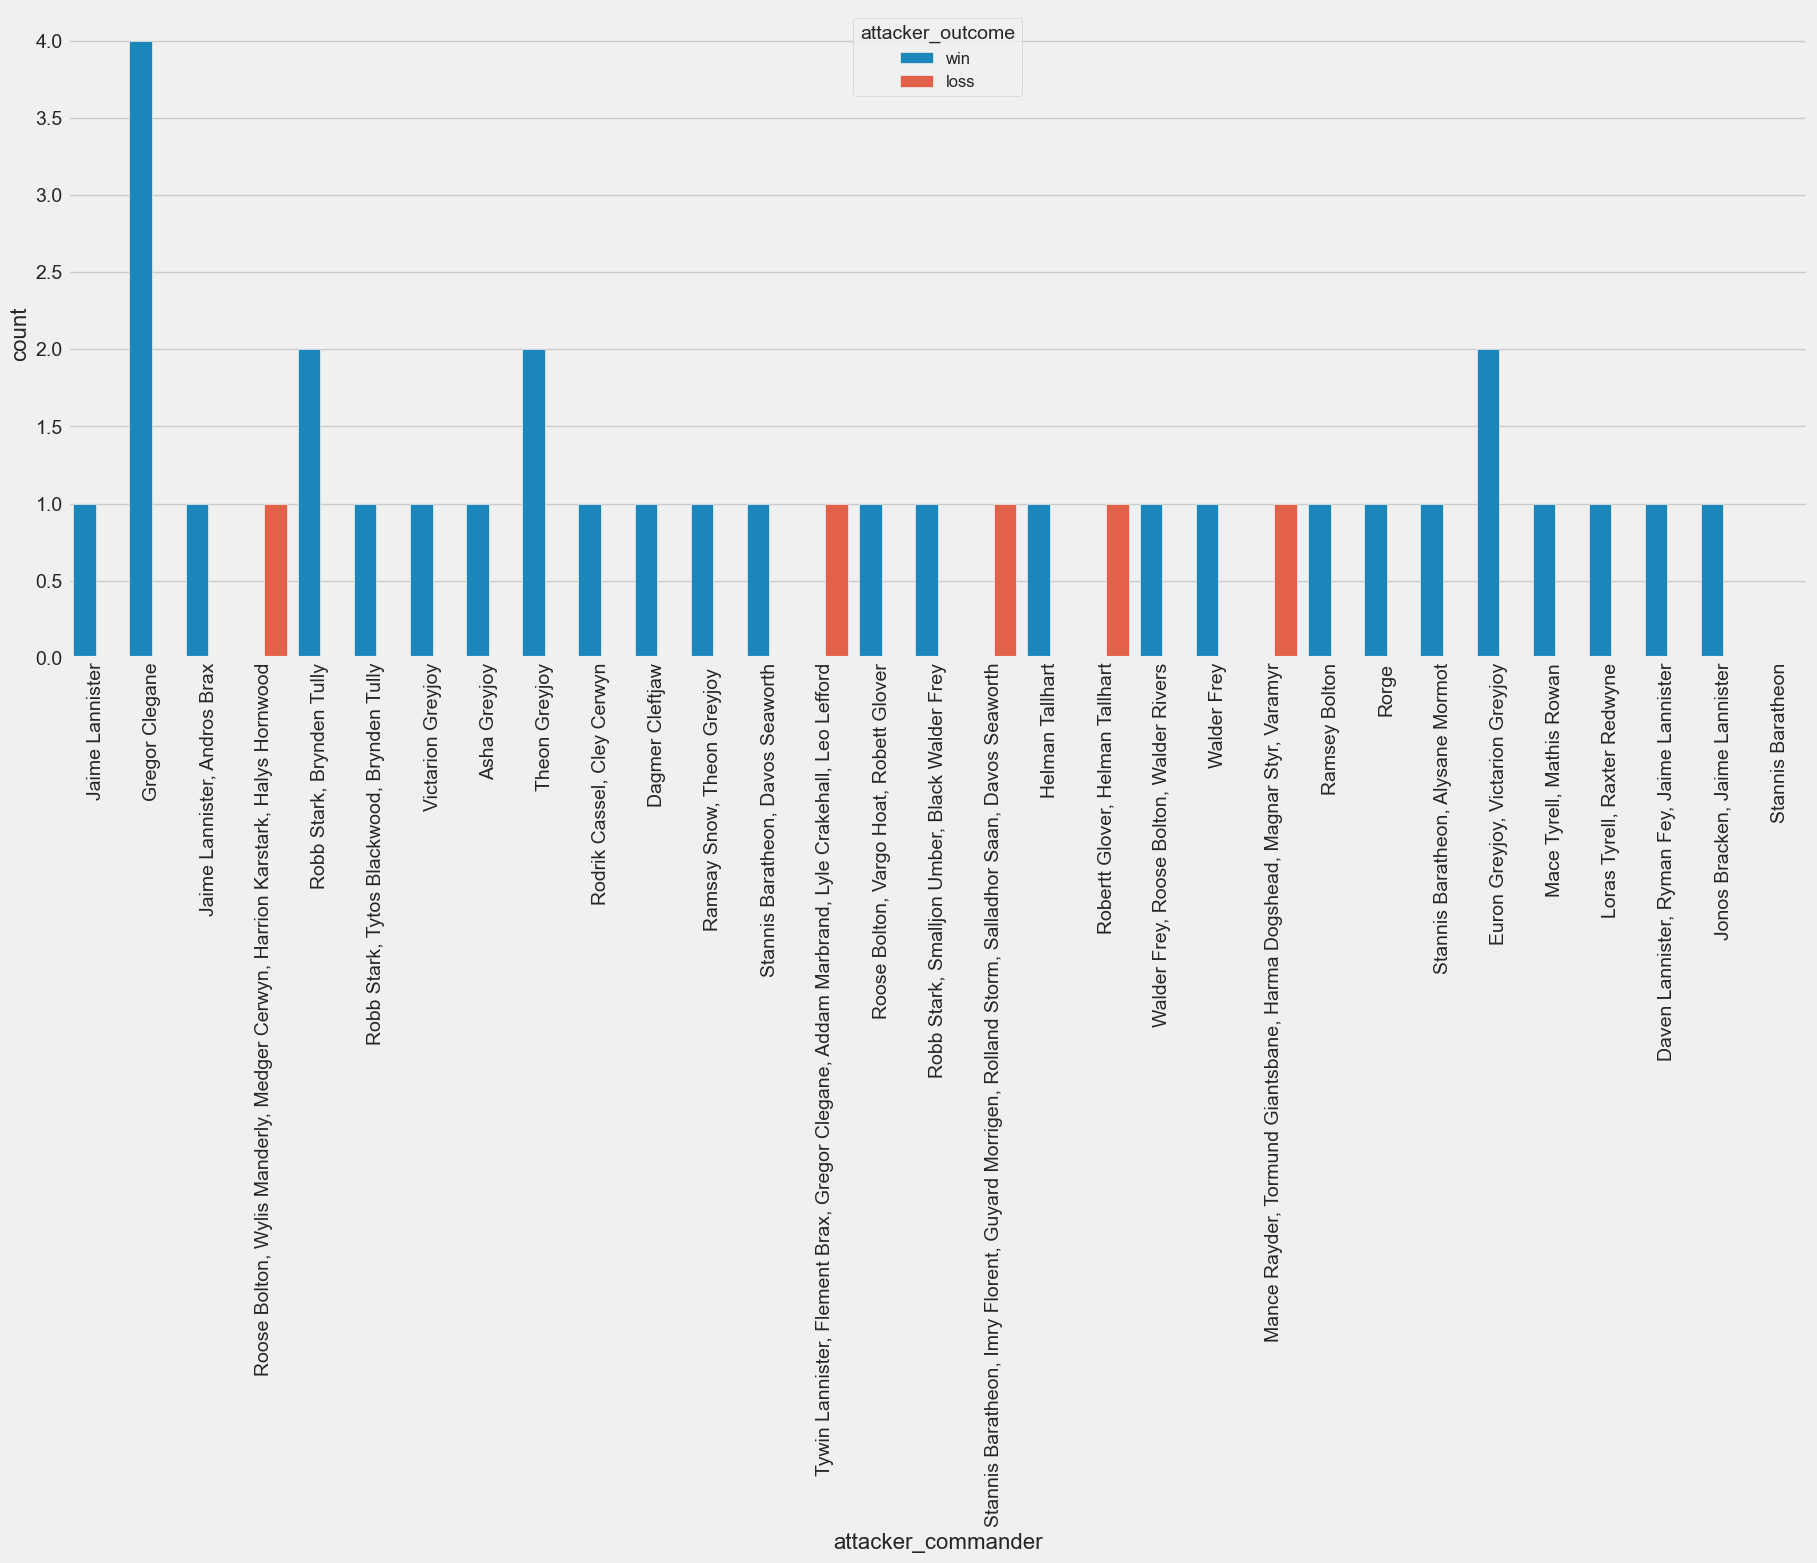

In [30]:
plt.figure(figsize=(20,8))
sns.countplot(battles['attacker_commander'],hue=battles['attacker_outcome']);
plt.xticks(rotation=90);

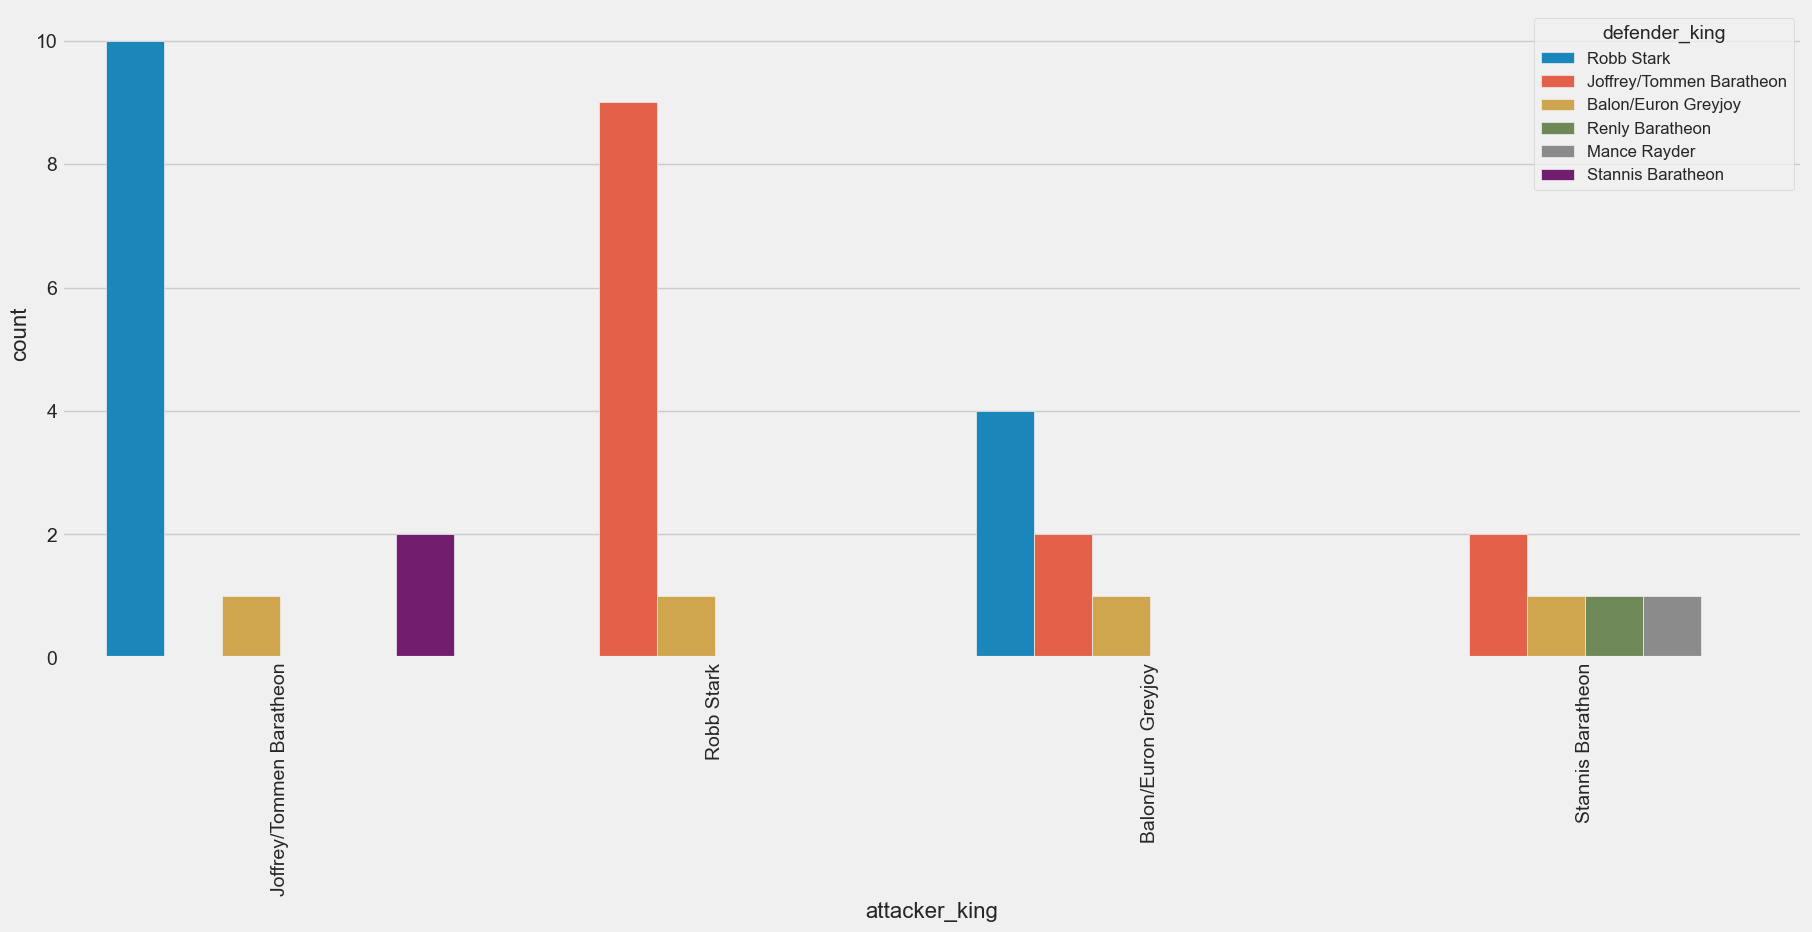

In [31]:
plt.figure(figsize=(20,8))
sns.countplot(battles['attacker_king'],hue=battles['defender_king']);
plt.xticks(rotation=90);

The first two columns are **"totaldefender"** and **"totalattacker"**, which count the number of non-null values in the columns **"defender_1"**, **"defender_2"**, **"defender_3"**, **"defender_4"** and **"attacker_1"**, **"attacker_2"**, **"attacker_3"**, **"attacker_4"**, respectively. The count is then subtracted from 4 to get the total number of defenders and attackers.

The third column is **"totalcommon"**, which counts the number of elements in the **"attacker_commander"** column that are separated by a comma. If the element is not a list (i.e., it is null), then the value in the **"totalcommon"** column is set to **NaN** .

In [32]:
battles.loc[:, "totaldefender"] = (4 - battles[["defender_1", "defender_2", "defender_3", "defender_4"]].isnull().sum(axis = 1))
battles.loc[:, "totalattacker"] = (4 - battles[["attacker_1", "attacker_2", "attacker_3", "attacker_4"]].isnull().sum(axis = 1))
battles.loc[:, "totalcommon"] = [len(x) if type(x) == list else np.nan for x in battles.attacker_commander.str.split(",")]

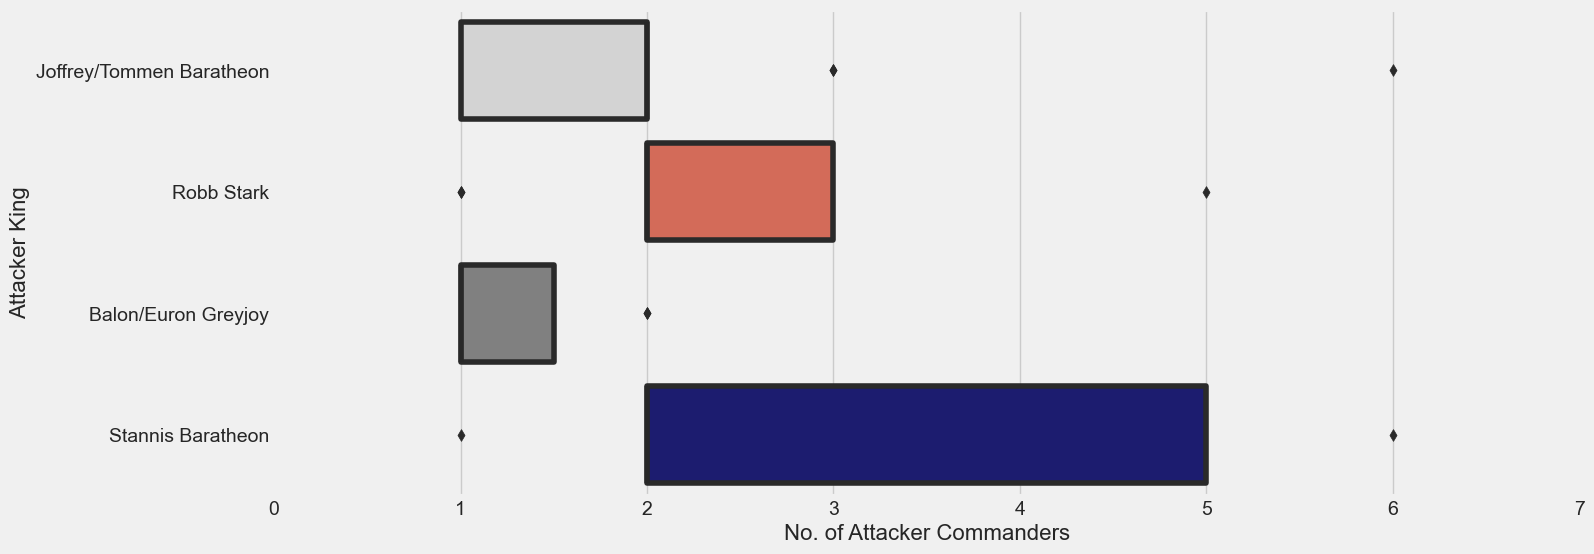

In [33]:
p = sns.boxenplot("totalcommon", "attacker_king", data = battles, saturation = .6,palette = ["lightgray", sns.color_palette()[1], "grey", "darkblue"])
_ = p.set(xlabel = "No. of Attacker Commanders", ylabel = "Attacker King", xticks = range(8))

In [34]:
battles['attacker_size'].mean()

9942.541666666666

In [35]:
battles['defender_size'].mean()

6428.1578947368425

In [36]:
nbdf = battles[['defender_size','attacker_size','attacker_outcome']].dropna()

In [37]:
nbdf.reset_index(inplace=True)

In [38]:
nbdf = nbdf.iloc[:,1:]

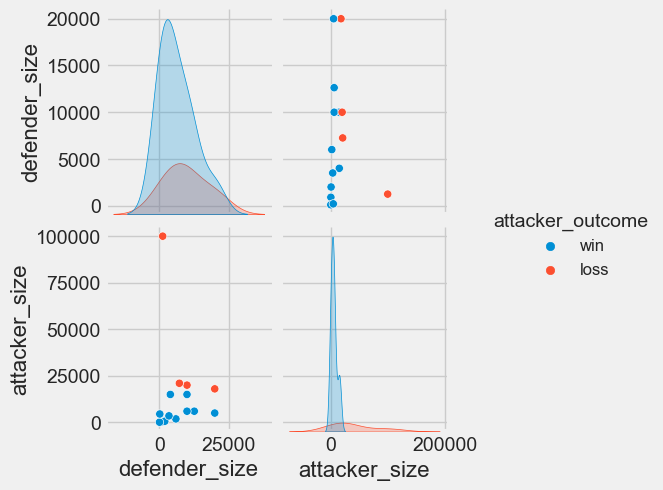

In [39]:
sns.pairplot(nbdf, hue='attacker_outcome');

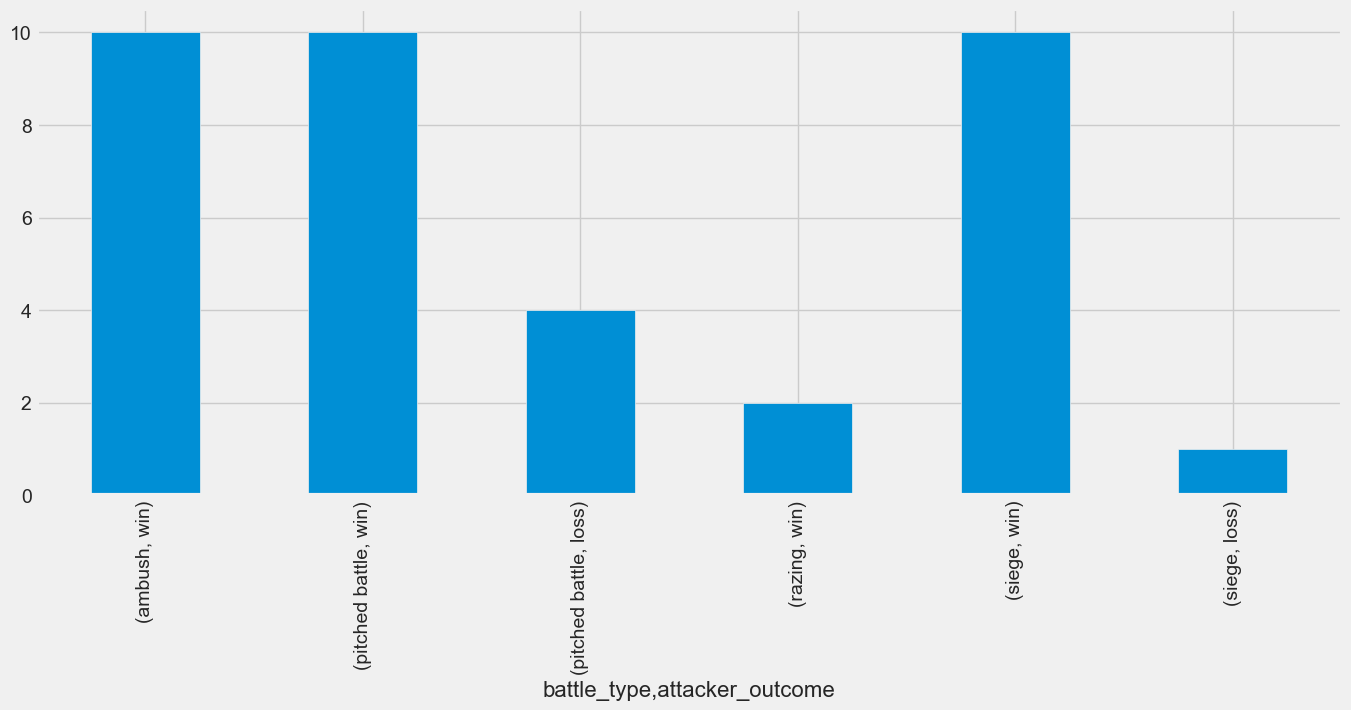

In [40]:
battles.groupby('battle_type')['attacker_outcome'].value_counts().plot(kind = 'bar');

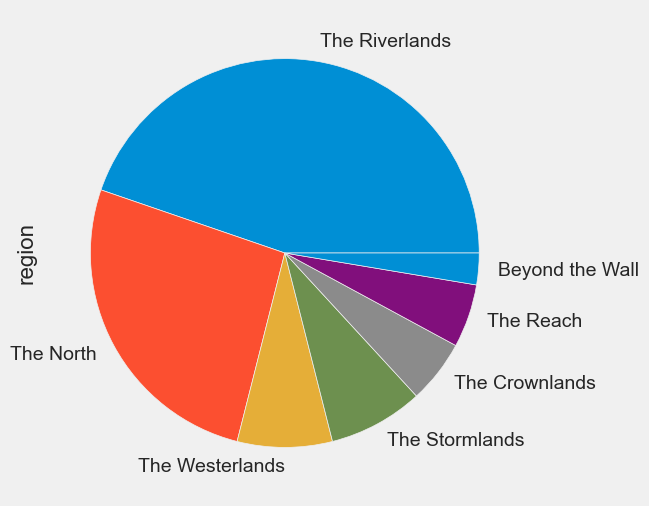

In [41]:
battles['region'].value_counts().plot(kind = 'pie');

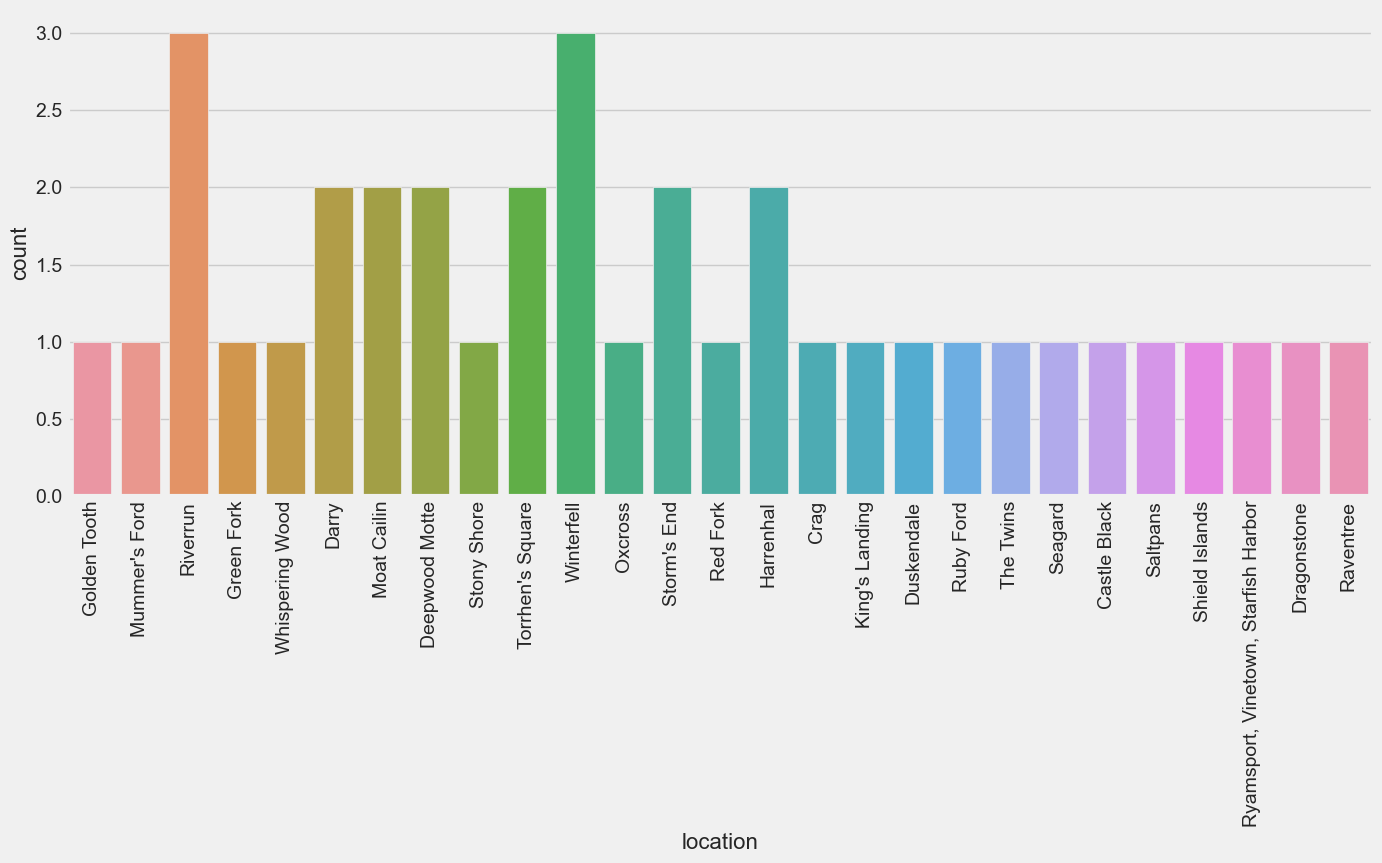

In [42]:
sns.countplot(x=battles['location'])
plt.xticks(rotation=90);

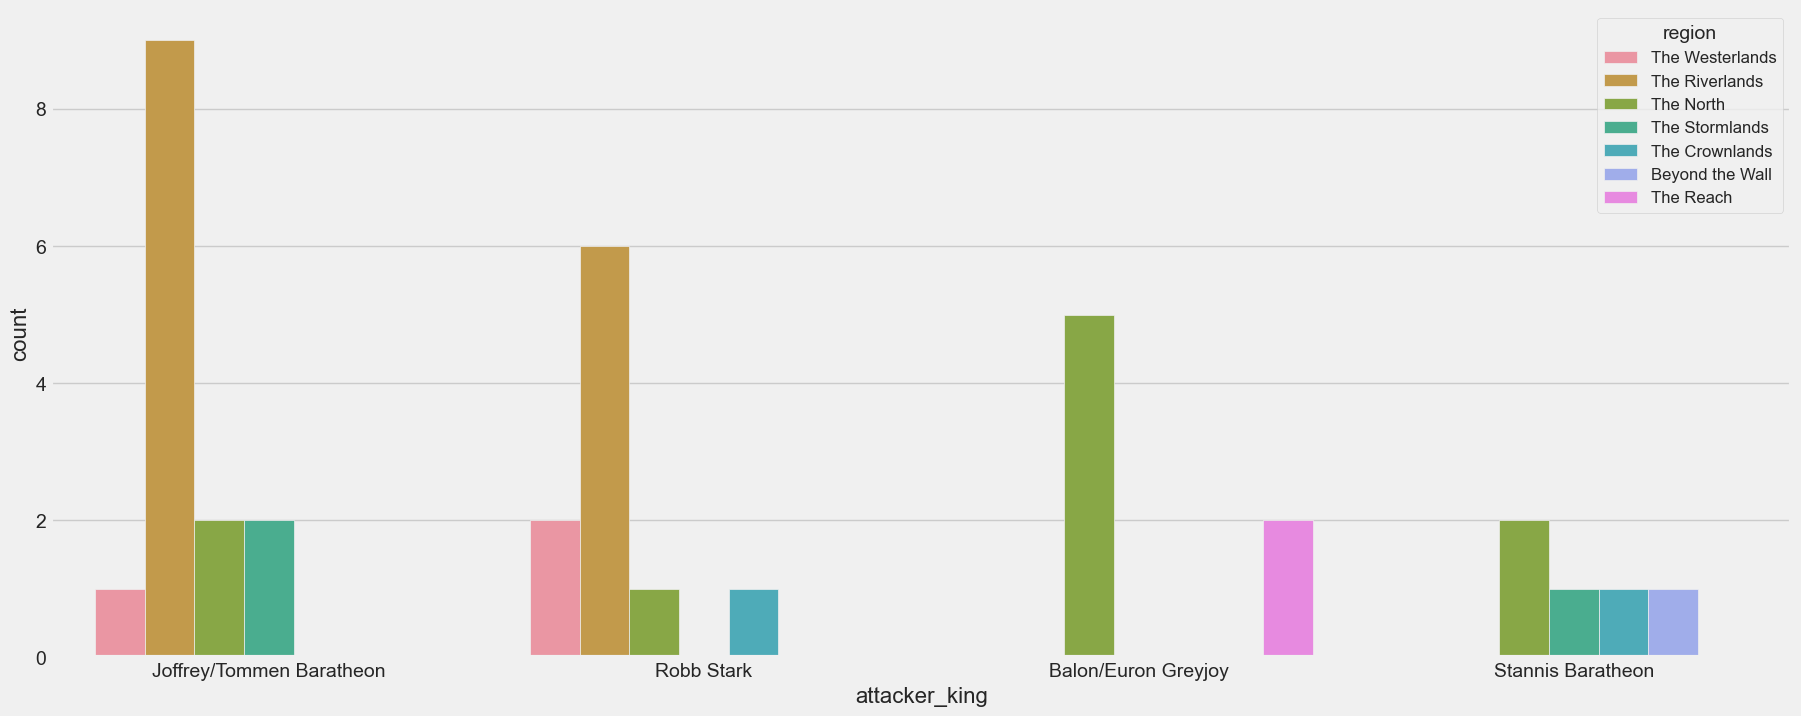

In [43]:
plt.figure(figsize=(20,8))
sns.countplot(battles['attacker_king'],hue=battles['region']);

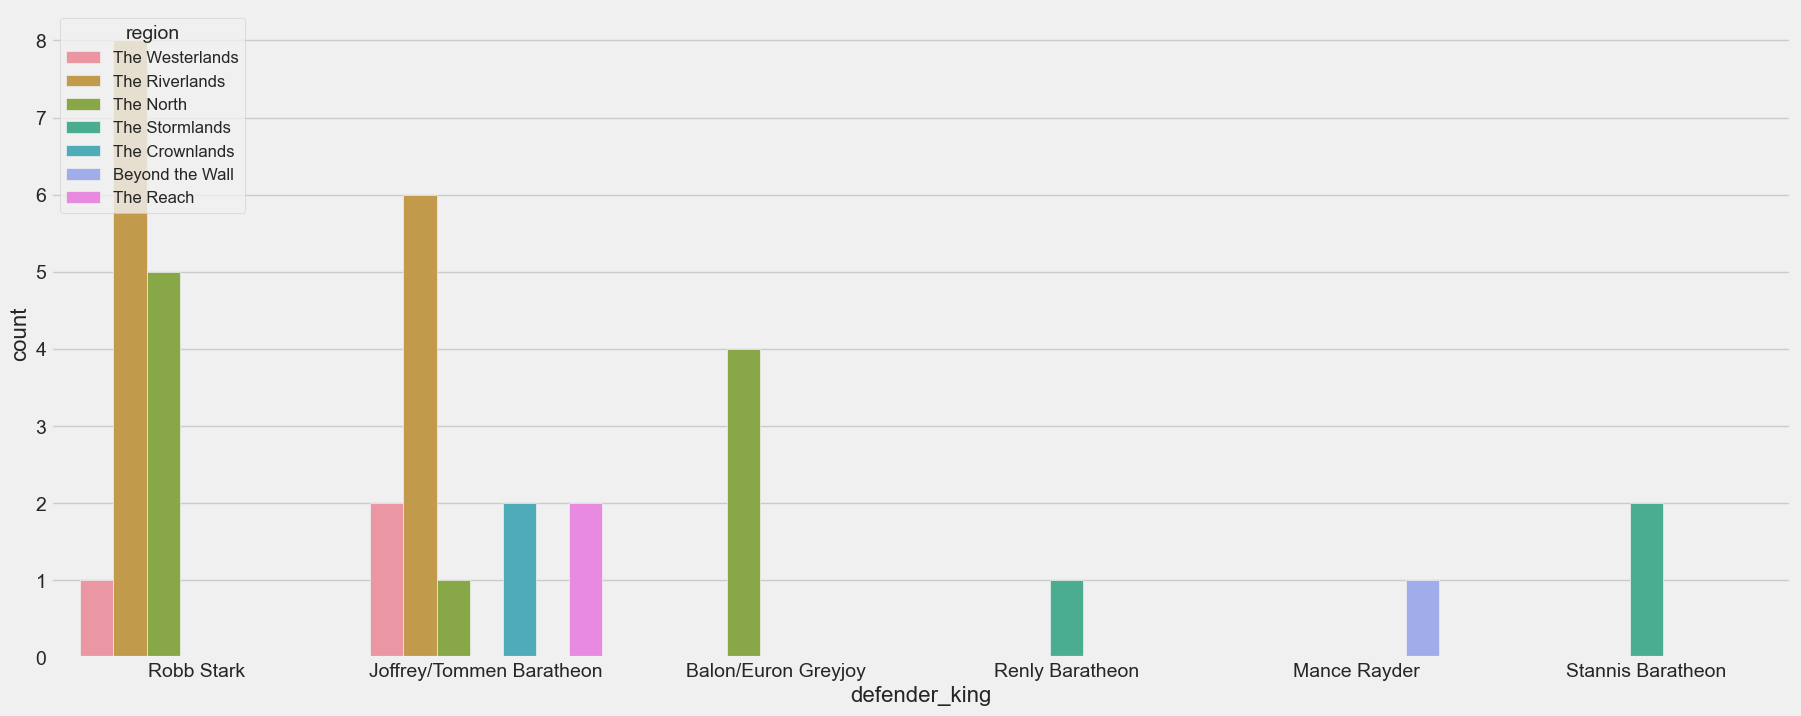

In [44]:
plt.figure(figsize=(20,8))
sns.countplot(battles['defender_king'],hue=battles['region']);

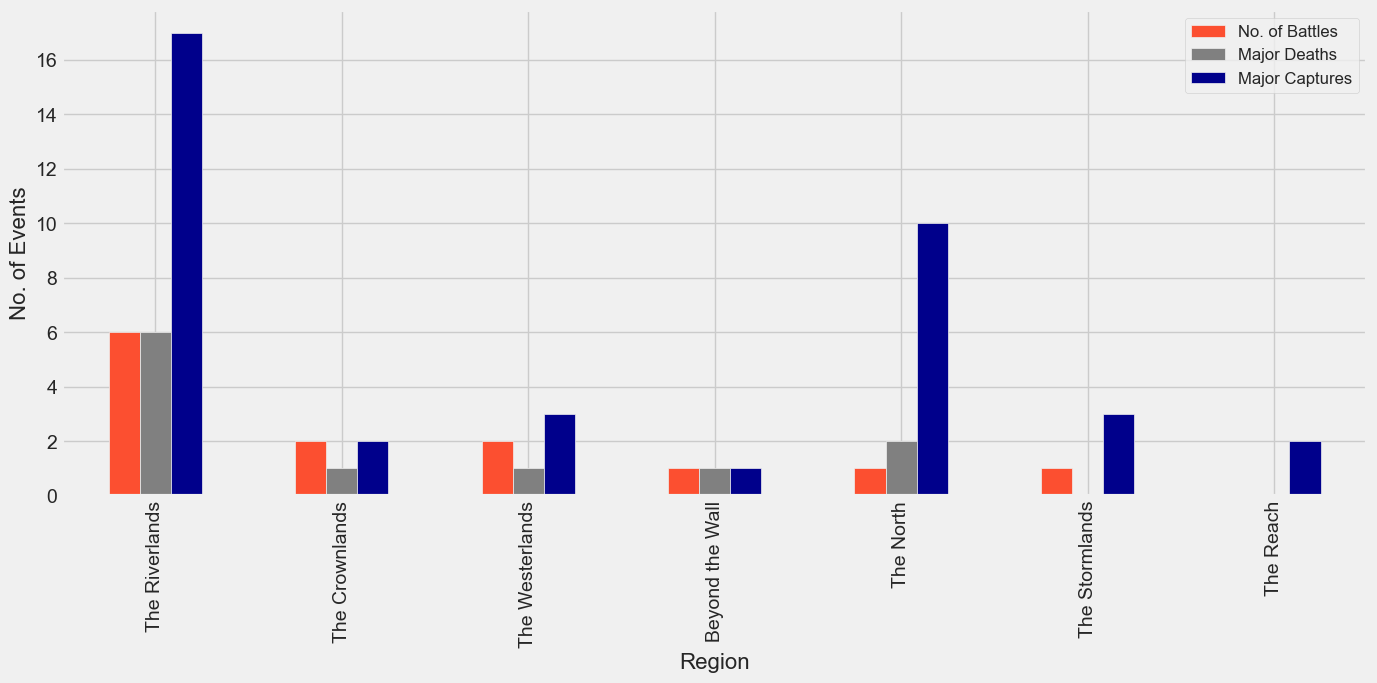

In [45]:
data = battles.groupby("region").sum()[["major_death", "major_capture"]]
p = pd.concat([data, battles.region.value_counts().to_frame()], axis = 1).sort_values("major_death", ascending = False).copy(deep = True).plot.bar(color = [sns.color_palette()[1], 
"grey", "darkblue"], rot = 0)
_ = p.set(xlabel = "Region", ylabel = "No. of Events"), p.legend(["No. of Battles", "Major Deaths", "Major Captures"], fontsize = 12.)
plt.xticks(rotation=90);

In [46]:
character_deaths['Allegiances'] = character_deaths['Allegiances'].apply(lambda x : 'House Martell' if(x == 'Martell') else 'House Stark' if(x=='Stark') else 'House Targaryen' if(x=='Targaryen') else 'House Tully' if(x=='Tully') else 'House Tyrell' if(x=='Tyrell') else x)

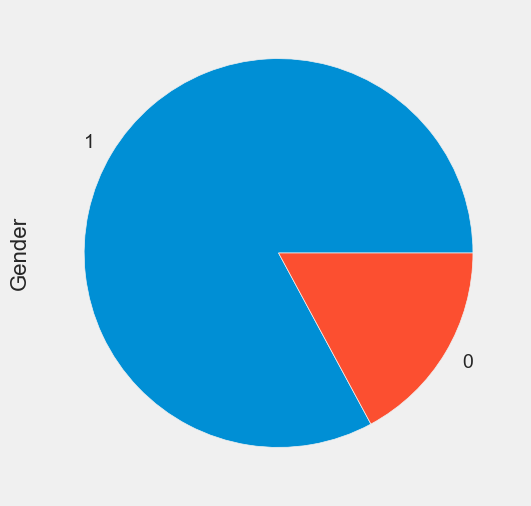

In [47]:
character_deaths['Gender'].value_counts().plot(kind = 'pie');

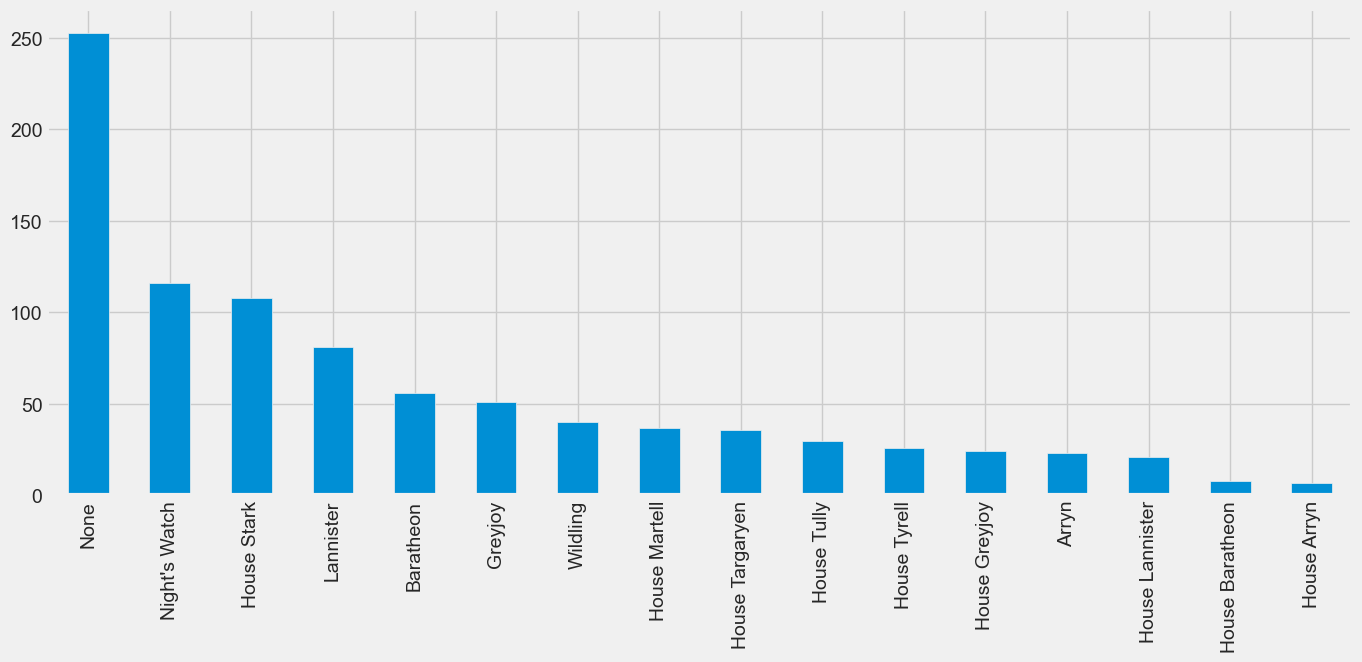

In [48]:
character_deaths['Allegiances'].value_counts().plot(kind = 'bar', stacked='True');

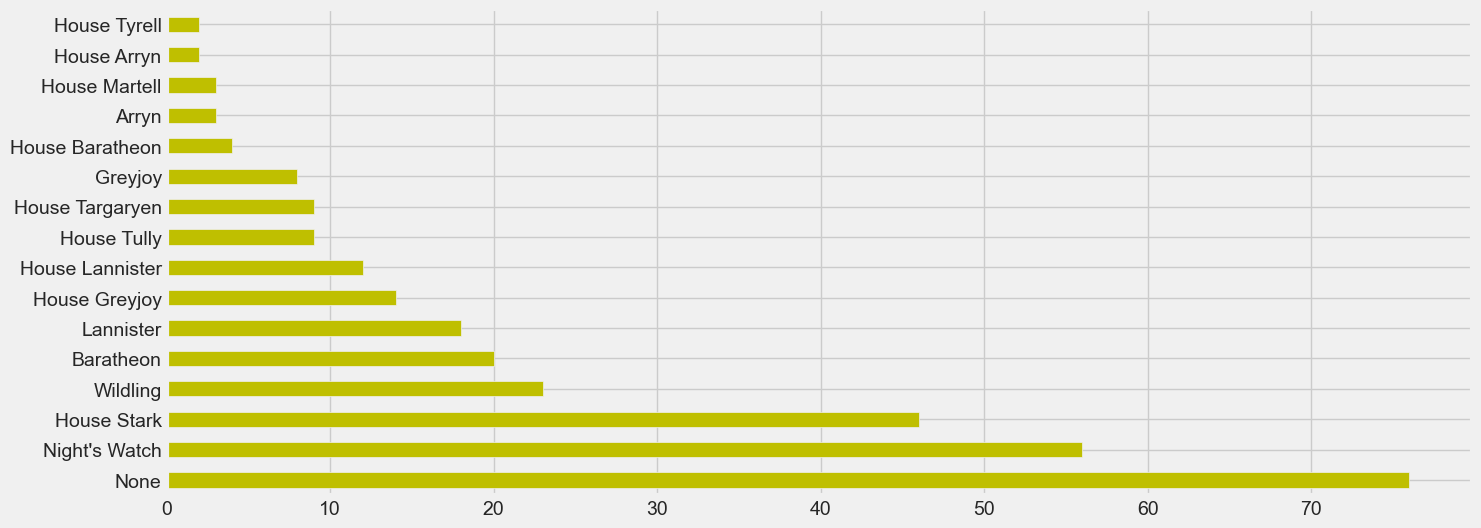

In [49]:
character_deaths[character_deaths['Death Year'].notnull()]['Allegiances'].value_counts().plot(kind = 'barh',color='y');

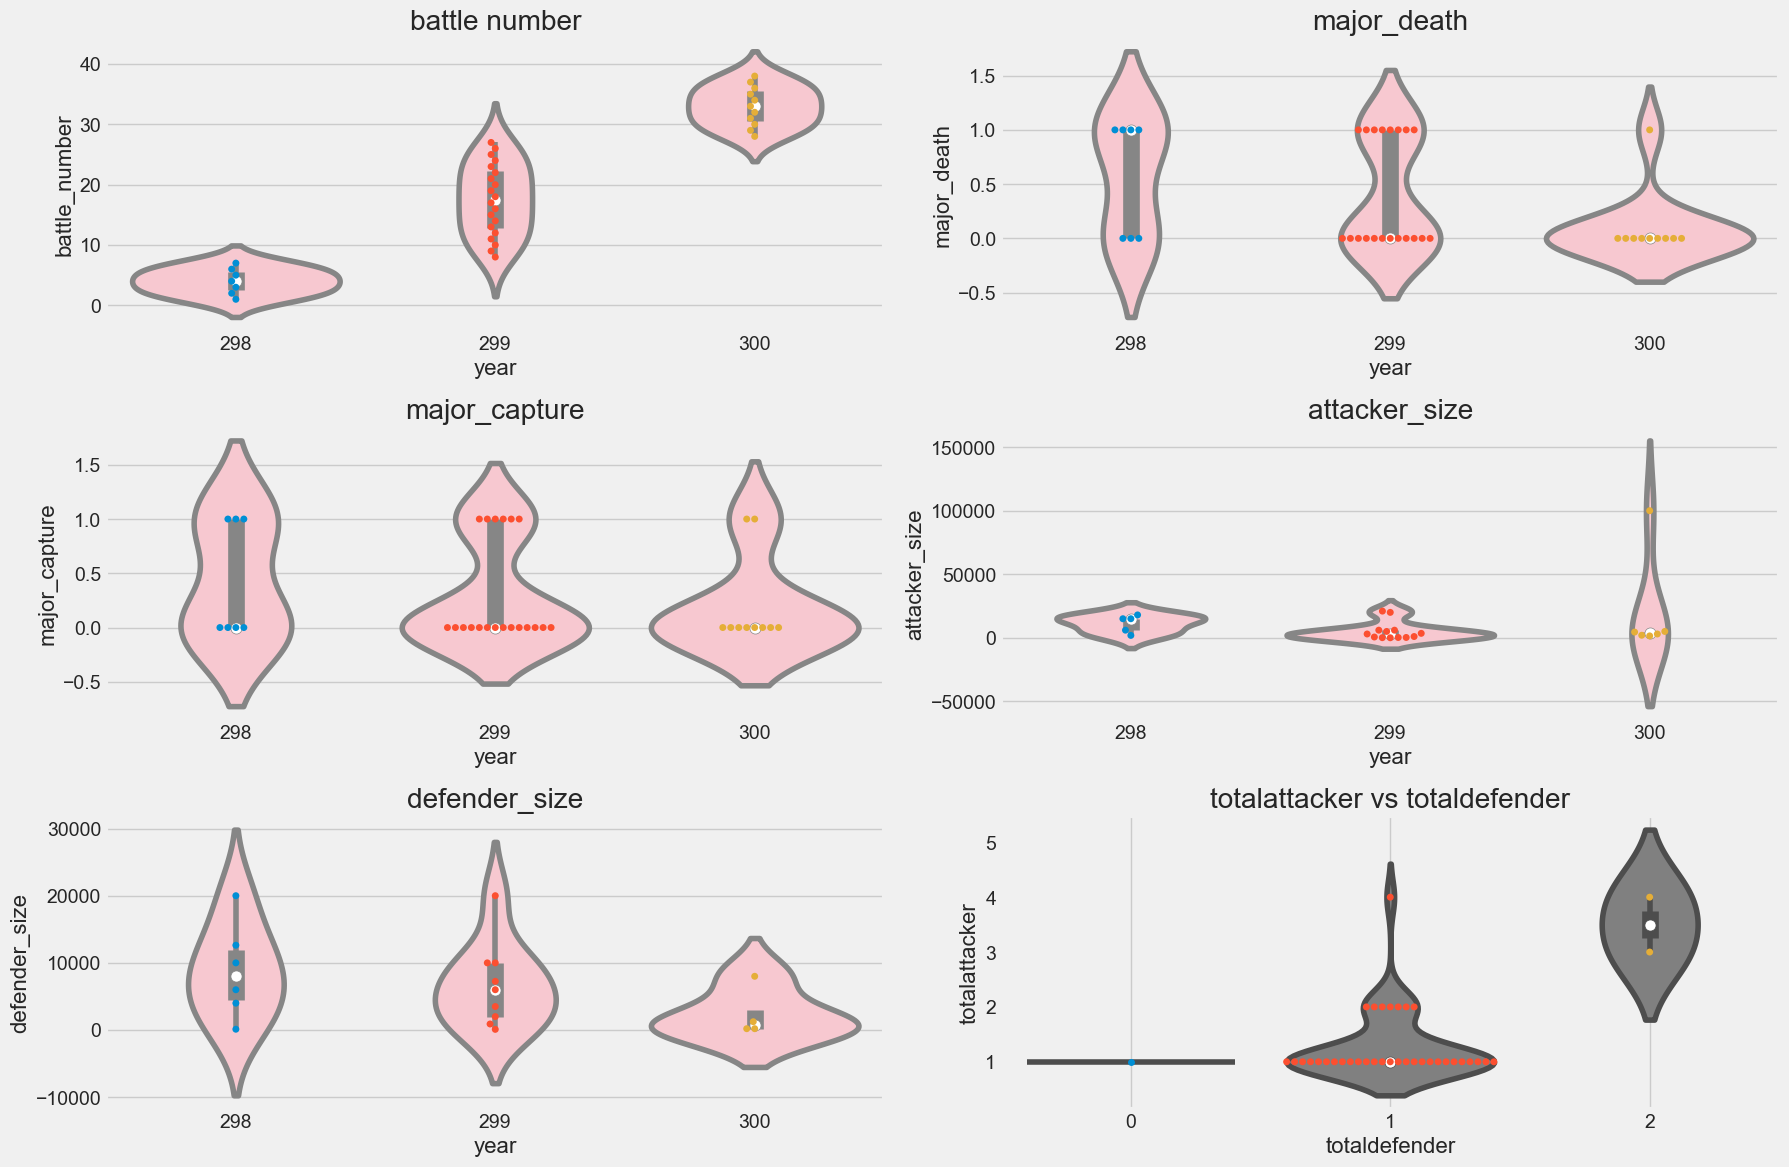

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
sns.violinplot(x="year", y="battle_number", data=battles,color = 'pink',ax=axes[0][0]).set_title('battle number')
sns.swarmplot(x="year", y="battle_number", data=battles,ax = axes[0][0])

sns.violinplot(x="year", y="major_death", data=battles,color = 'pink',ax=axes[0][1]).set_title('major_death')
sns.swarmplot(x="year", y="major_death", data=battles,ax = axes[0][1])

sns.violinplot(x="year", y="major_capture", data=battles,color = 'pink',ax=axes[1][0]).set_title('major_capture')
sns.swarmplot(x="year", y="major_capture", data=battles,ax = axes[1][0])

sns.violinplot(x="year", y="attacker_size", data=battles,color = 'pink',ax=axes[1][1]).set_title('attacker_size')
sns.swarmplot(x="year", y="attacker_size", data=battles,ax = axes[1][1])

sns.violinplot(x="year", y="defender_size", data=battles,color = 'pink',ax=axes[2][0]).set_title('defender_size')
sns.swarmplot(x="year", y="defender_size", data=battles,ax = axes[2][0])

sns.violinplot(x="totaldefender", y="totalattacker", data=battles,color = 'gray',ax=axes[2][1]).set_title('totalattacker vs totaldefender')
sns.swarmplot(x="totaldefender", y="totalattacker", data=battles,ax = axes[2][1])

plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [51]:
death_preds = character_predictions.copy(deep = True)

# Predictive Experiment

## A bit of preprocessing
The code is performing some data preprocessing steps, such as factorizing categorical variables, dropping irrelevant columns, and replacing missing values with -1. These steps are commonly used to prepare data for machine learning models, so it's possible that the code is part of a larger data preparation pipeline.

In [52]:
death_preds.loc[:, "culture"] = [get_cult(x) for x in death_preds.culture.fillna("")]
death_preds.loc[:, "title"] = pd.factorize(death_preds.title)[0]
death_preds.loc[:, "culture"] = pd.factorize(death_preds.culture)[0]
death_preds.loc[:, "mother"] = pd.factorize(death_preds.mother)[0]
death_preds.loc[:, "father"] = pd.factorize(death_preds.father)[0]
death_preds.loc[:, "heir"] = pd.factorize(death_preds.heir)[0]
death_preds.loc[:, "house"] = pd.factorize(death_preds.house)[0]
death_preds.loc[:, "spouse"] = pd.factorize(death_preds.spouse)[0]

death_preds.drop(["name", "alive", "pred", "plod", "isAlive", "dateOfBirth"], 1, inplace = True)
death_preds.columns = map(lambda x: x.replace(".", "").replace("_", ""), death_preds.columns)
death_preds.fillna(value = -1, inplace = True)

## Is there a class imbalance?
The code creates a figure with two subplots, each showing the distribution of the "actual" variable in the "death_preds" dataframe. The first subplot is a bar plot and the second one is a pie chart. The title of the figure is "Class Distribution". The first subplot shows the count of each class (Alive and Deceased) on the y-axis and the class names on the x-axis. The second subplot shows the percentage of each class on the pie chart and also includes the percentage values as labels. The colors used for the two classes are taken from the seaborn color palette.

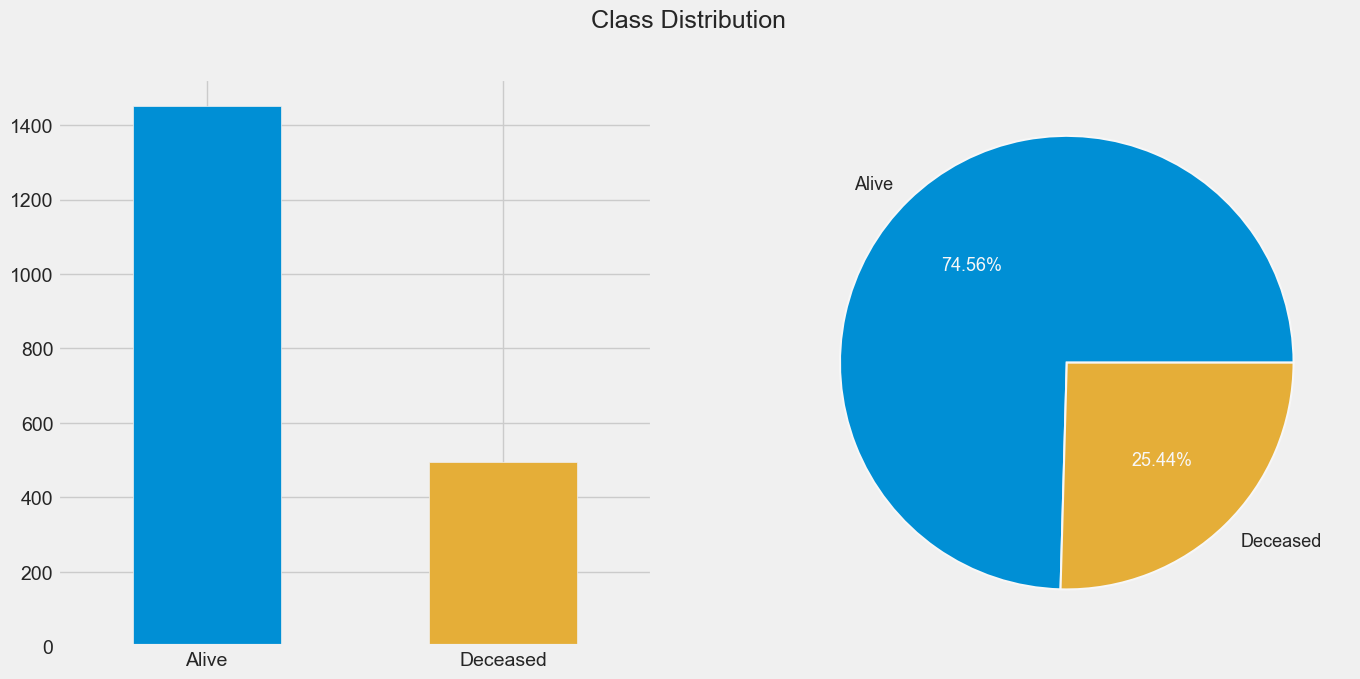

In [53]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Class Distribution", fontsize = 18.)
_ = death_preds.actual.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[0], sns.color_palette()[2])).set(xticklabels = ["Alive", "Deceased"])
_ = death_preds.actual.value_counts().plot.pie(labels = ("Alive", "Deceased"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[2]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

The code is creating a train and test split of the data, with the train set containing 350 samples each from the "Alive" and "Deceased" classes. It is then dropping some columns from the X and tX datasets.

In [54]:
X = death_preds[death_preds.actual == 0].sample(350, random_state = 62).append(death_preds[death_preds.actual == 1].sample(350, random_state = 62)).copy(deep = True).astype(np.float64)
Y = X.actual.values
tX = death_preds[~death_preds.index.isin(X.index)].copy(deep = True).astype(np.float64)
tY = tX.actual.values
X.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)
tX.drop(["SNo", "actual", "DateoFdeath"], 1, inplace = True)

## XGB Classifier
The  code fits an **XGBoost classifier (clf_xgb)** on the training data (X and Y) and makes predictions on the testing data (tX). It then generates a bar plot of the feature importance scores of the XGBoost model, using the **get_fscore()** method of the booster object. The plot is sorted in ascending order of feature importance scores.

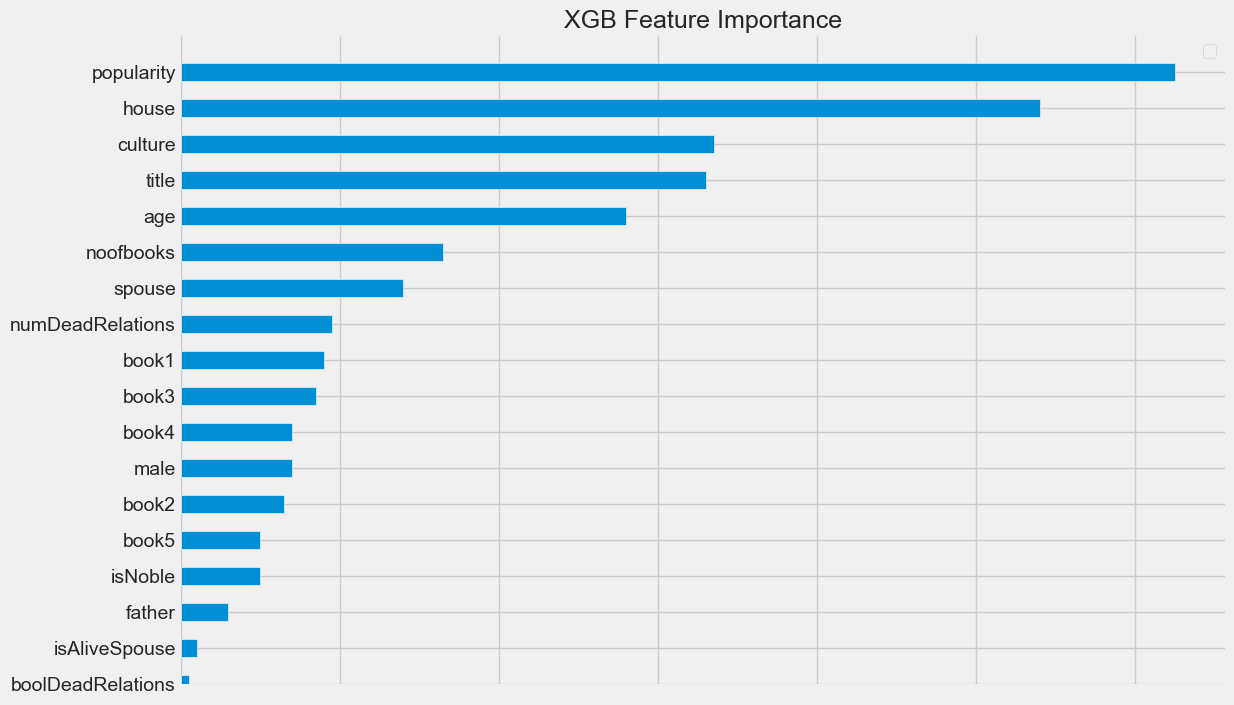

In [55]:
clf_xgb = XGBC(subsample = .8, colsample_bytree = .8, seed = 14, max_depth = 3).fit(X, Y)
preds_xgb = clf_xgb.predict_proba(tX)
ax = pd.DataFrame(list(clf_xgb.get_booster().get_fscore().items())).set_index(0)\
.sort_values(1).plot.barh(figsize = (12, 8))
_ = ax.set(frame_on = False, ylim = (0, len(clf_xgb.get_booster().get_fscore())), xticklabels = "", xlabel = "", ylabel = ""), ax.legend("")
_ = plt.title("XGB Feature Importance", fontsize = 18.)

## Logistic Regression
The code provided performs logistic regression on the data and plots the coefficients for each feature. The coefficients indicate the strength and direction of the relationship between each feature and the target variable (i.e., whether a character is alive or deceased). A positive coefficient means that an increase in the feature value is associated with an increased likelihood of being alive, while a negative coefficient indicates the opposite. The plot allows us to see which features are the strongest predictors of mortality in the model.

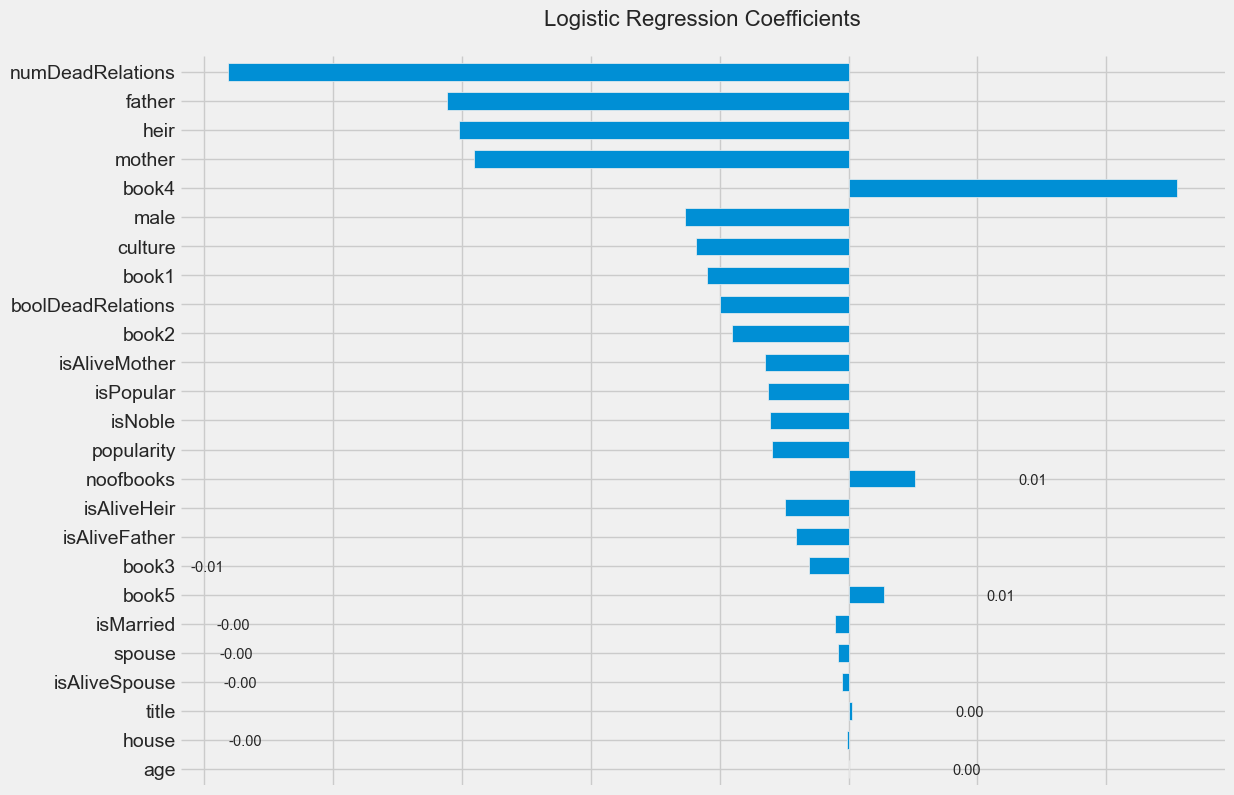

In [56]:
logreg = LogisticRegression(random_state = 14).fit(X, Y)
preds_lr = logreg.predict_proba(tX)

df = pd.DataFrame(list(zip(tX.columns, logreg.coef_[0])))
df = df.reindex(df[1].abs().sort_values().index).set_index(0)
ax = df.plot.barh(width = .6, legend = "", figsize = (12, 9))
ax.set_title("Logistic Regression Coefficients", y = 1.03, fontsize = 16.)
_ = ax.set(frame_on = False, xlabel = "", xticklabels = "", ylabel = "")

for i, label in enumerate(list(df.index)):
    score = df.loc[label][1]
    ax.annotate('%.2f' % score, (score + (-.12 if score < 0 else .02), i - .2), fontsize = 10.5)

## Comparison of XGB Classifier and Logistic Regression

### Confusion Matrix
The code generates two normalized confusion matrices for the **XGB Classifier** and the **Logistic Regression model**. The confusion matrices show the actual versus predicted values for the two classes (**Deceased** and **Alive**).

The first confusion matrix shows the performance of the XGB Classifier. The top left cell shows the percentage of correctly predicted Deceased instances, and the bottom right cell shows the percentage of correctly predicted Alive instances. The top right cell shows the percentage of instances that were incorrectly predicted as Alive when they were actually Deceased, and the bottom left cell shows the percentage of instances that were incorrectly predicted as Deceased when they were actually Alive.

The second confusion matrix shows the performance of the Logistic Regression model. The layout is the same as for the XGB Classifier.

Both models seem to perform relatively well, with high percentages of correct predictions for both classes. However, the **Logistic Regression model seems to have a slightly better performance for predicting the Alive class**, as indicated by the bottom right cell of its confusion matrix, which shows a higher percentage of correct predictions for this class compared to the XGB Classifier.

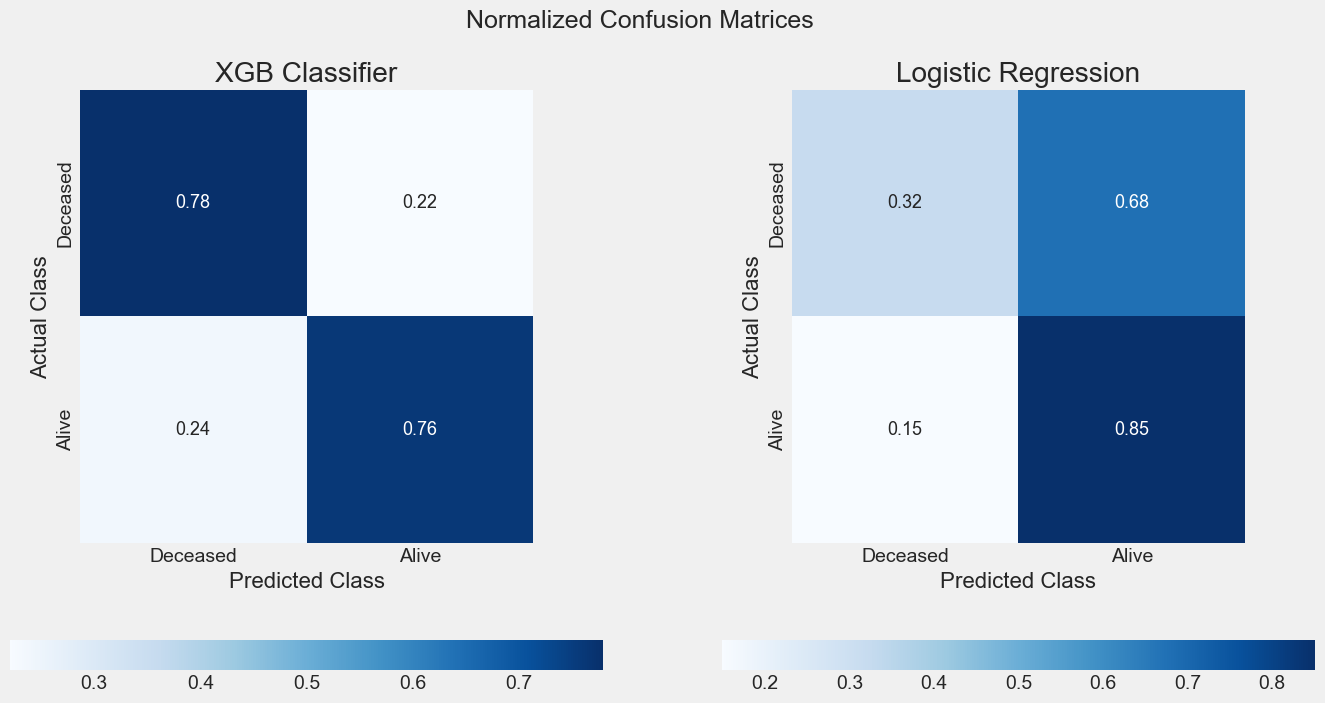

In [57]:
f, ax = plt.subplots(1, 2, figsize = (15, 8))
f.suptitle("Normalized Confusion Matrices", fontsize = 18.)
def make_cm(p, t, axis):
    cm = confusion_matrix(tY, np.argmax(p, axis = 1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True,
                    annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                    cbar = True, cbar_kws = {"orientation": "horizontal"}, ax = ax[axis], cmap = "Blues").set(
        xlabel = "Predicted Class", ylabel = "Actual Class", title = t)
make_cm(preds_xgb, "XGB Classifier", 0)
make_cm(preds_lr, "Logistic Regression", 1)

### Scorecard
Next, we see the scorecard of both models. We use the handy `classification_report` and a number of other functions from `sklearn.metrics` to look at different evaluation metrics such as AUC, log loss, and accuracy.

In [58]:
print("XGB Classifier Performance\n" + "=" * 26 + "\n", classification_report(tY, np.argmax(preds_xgb, axis = 1), target_names = ["Deceased", "Alive"]))
print("AUC      : %.4f" % roc_auc_score(tY, preds_xgb[:, 1]))
print("Accuracy : %.4f" % accuracy_score(tY, np.argmax(preds_xgb, axis = 1)))
print("Log Loss : %.4f\n\n" % log_loss(tY, preds_xgb[:, 1]))
print("Logistic Regression Performance\n" + "=" * 31 + "\n", classification_report(tY, np.argmax(preds_lr, axis = 1), target_names = ["Deceased", "Alive"]))
print("AUC      : %.4f" % roc_auc_score(tY, preds_lr[:, 1]))
print("Accuracy : %.4f" % accuracy_score(tY, np.argmax(preds_lr, axis = 1)))
print("Log Loss : %.4f" % log_loss(tY, preds_lr[:, 1]))

XGB Classifier Performance
               precision    recall  f1-score   support

    Deceased       0.30      0.78      0.43       145
       Alive       0.96      0.76      0.85      1101

    accuracy                           0.76      1246
   macro avg       0.63      0.77      0.64      1246
weighted avg       0.89      0.76      0.80      1246

AUC      : 0.8291
Accuracy : 0.7632
Log Loss : 0.5448


Logistic Regression Performance
               precision    recall  f1-score   support

    Deceased       0.22      0.32      0.26       145
       Alive       0.91      0.85      0.88      1101

    accuracy                           0.79      1246
   macro avg       0.56      0.59      0.57      1246
weighted avg       0.83      0.79      0.81      1246

AUC      : 0.6207
Accuracy : 0.7897
Log Loss : 0.6378


### ROC Curves
**ROC (Receiver Operating Characteristic)** plot is a graphical representation of the performance of a binary classifier system. The plot shows the trade-off between the true positive rate (**TPR**) and the false positive rate (**FPR**) of the classifier for various threshold values.

The TPR, also called **sensitivity** or **recall**, is the proportion of actual positive cases that are correctly identified as positive by the classifier. The FPR is the proportion of actual negative cases that are incorrectly identified as positive by the classifier.

In a ROC plot, the **TPR is plotted on the y-axis** and the **FPR is plotted on the x-axis**. The plot shows the performance of the classifier for all possible threshold values, which range from 0 to 1.

A perfect classifier would have a TPR of 1 and an FPR of 0, resulting in a point at the top left corner of the plot. A random classifier would have a diagonal line, from the bottom left to the top right corner of the plot. **The closer the ROC curve is to the top left corner, the better the performance of the classifier**.

The ROC plot is useful for comparing the performance of different classifiers or for selecting an optimal threshold value for a particular classifier based on the desired TPR and FPR. The area under the ROC curve (AUC) is also commonly used as a summary measure of the performance of the classifier. A perfect classifier would have an AUC of 1, while a random classifier would have an AUC of 0.5.

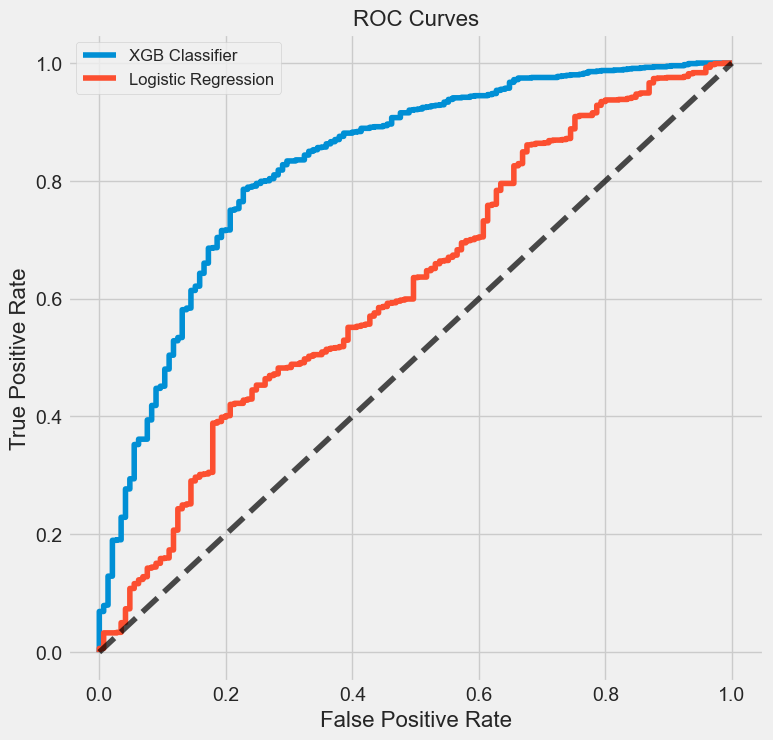

In [59]:
_ = plt.figure(figsize = (8, 8)), plt.plot(*roc_curve(tY, preds_xgb[:, 1])[:2]), plt.plot(*roc_curve(tY, preds_lr[:, 1])[:2], c = sns.color_palette()[1]), plt.legend(["XGB Classifier", "Logistic Regression"], loc = "upper left")
_ = plt.plot((0., 1.), (0., 1.), "--k", alpha = .7), plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate"), plt.title("ROC Curves", fontsize = 16.)

# Thank You
## The end.